# Báo cáo: Mô hình dự đoán phá sản

Trong dự án này, nhóm xây dựng một mô hình dự đoán nguy cơ phá sản của doanh nghiệp thông qua việc sử dụng các thuật toán học máy. Mục tiêu của mô hình là xác định liệu một công ty có khả năng rơi vào tình trạng phá sản hay không, dựa trên các chỉ số phản ánh hiệu quả hoạt động và tình hình tài chính của doanh nghiệp.

Bộ dữ liệu phục vụ cho quá trình huấn luyện và đánh giá mô hình được lưu trong tệp `bankruptcy_data.xlsx`. Bộ dữ liệu bao gồm nhiều đặc trưng tài chính quan trọng, đại diện cho các khía cạnh khác nhau của hoạt động doanh nghiệp.

- **EPS (Earnings Per Share)**: Lợi nhuận trên mỗi cổ phiếu, phản ánh mức lợi nhuận mà công ty tạo ra cho mỗi cổ phần đang lưu hành.

- **Liquidity**: Chỉ số thanh khoản, thể hiện khả năng chuyển đổi tài sản thành tiền mặt nhanh chóng mà không làm giảm giá trị tài sản.

- **Profitability**: Khả năng sinh lời của doanh nghiệp trong quá trình hoạt động.

- **Productivity**: Năng suất hoạt động, đo lường mức độ hiệu quả trong việc tạo ra sản phẩm hoặc giá trị.

- **Leverage Ratio**: Tỷ lệ đòn bẩy tài chính, phản ánh mức độ sử dụng nợ so với vốn chủ sở hữu.

- **Asset Turnover**: Vòng quay tài sản, cho biết mức độ hiệu quả của việc sử dụng tài sản để tạo doanh thu.

- **Operational Margin**: Biên lợi nhuận hoạt động, thể hiện khả năng sinh lời từ hoạt động kinh doanh cốt lõi trước lãi vay và thuế.

- **ROE (Return on Equity)**: Lợi nhuận trên vốn chủ sở hữu.

- **Market Book Ratio**: Tỷ lệ giá thị trường trên giá sổ sách, phản ánh kỳ vọng của thị trường đối với giá trị doanh nghiệp.

- **Assets Growth**: Tốc độ tăng trưởng tài sản.

- **Sales Growth**: Tốc độ tăng trưởng doanh thu.

- **Employee Growth**: Tốc độ tăng trưởng nhân sự.

Biến mục tiêu của bài toán là `BK`, biểu thị tình trạng phá sản của doanh nghiệp, trong đó:

- 1: Doanh nghiệp phá sản

- 0: Doanh nghiệp không phá sản


[Xem dữ liệu tại đây](https://docs.google.com/spreadsheets/d/1nSUkK39x1m8JKs1ZQWuwcHmi8tKf8m2v/edit?usp=sharing&ouid=104296466586453342123&rtpof=true&sd=true)

## **1. Chuẩn bị dữ liệu**

### 1.1. Import các thư viện và tải các gói cần thiết

In [4]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [5]:
# Thiết lập các tùy chọn hiển thị
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.4f}'.format
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 2)

%matplotlib inline

In [6]:
# Các thư viện cho việc xây dựng mô hình
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize
from imblearn.datasets import fetch_datasets
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import (
    SMOTE,
    BorderlineSMOTE,
    SVMSMOTE,
)

from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler
)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### 1.2. Đọc dữ liệu

In [7]:
df = pd.read_excel("bankruptcy_data.xlsx")

In [8]:
# Kiểm tra kết quả của việc đọc dữ liệu
df.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1.5800,0.3600,0.1800,0.1300,1.3300,1.7700,0.0700,0.1500,2.2200,NaN,NaN,NaN,0
1,1.4100,0.3600,0.1900,0.1200,1.3100,1.5900,0.0700,0.1300,2.4100,0.1263,0.0143,0.0402,0
2,0.3100,0.3200,0.1300,0.0800,1.0300,1.5500,0.0500,0.0400,2.5600,0.3681,0.3279,0.5665,0


In [9]:
df.shape

(92872, 13)

In [10]:
# Sao lưu dữ liệu gốc
df_orig = df.copy()

## **2. Khám phá dữ liệu**

### 2.1. Kiểu dữ liệu

In [11]:
# Xem số lượng và kiểu dữ liệu của từng cột (thuộc tính)
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 92872 entries, 0 to 92871
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EPS                 92867 non-null  float64
 1   Liquidity           92625 non-null  float64
 2   Profitability       92625 non-null  float64
 3   Productivity        92625 non-null  float64
 4   Leverage Ratio      92846 non-null  float64
 5   Asset Turnover      92625 non-null  float64
 6   Operational Margin  87315 non-null  float64
 7   Return on Equity    92864 non-null  float64
 8   Market Book Ratio   92815 non-null  float64
 9   Assets Growth       86171 non-null  float64
 10  Sales Growth        86171 non-null  float64
 11  Employee Growth     85862 non-null  float64
 12  BK                  92872 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 9.2 MB


**Nhận xét**
- Bộ dữ liệu có kích thước lớn bao gồm 92872 quan trắc với 13 đặc trưng.

- Toàn bộ các cột đều thuộc kiểu **float**, ngoại trừ biến mục tiêu **BK** là **int (nhị phân)**. Không có biến dạng chuỗi hoặc dạng phân loại.

- Biến mục tiêu `BK` là biến định tính nhị phân (kiểu `int64`), nhận giá trị 0 hoặc 1. Các biến còn lại là các biến định lượng (kiểu `float64`), đại diện cho các chỉ số tài chính.

- Dữ liệu tồn tại các giá trị bị khuyết ở nhiều cột, đặc biệt là các cột `Employee Growth`, `Assets Growth`, `Sales Growth` và `Operational Margin` có số lượng mẫu thực tế thấp hơn đáng kể so với tổng số quan sát.

**Ý nghĩa:**

* Bộ dữ liệu đã ở dạng **sẵn sàng cho Machine Learning**, không cần mã hóa (encoding).
* Các mô hình học máy sẽ dễ dàng xử lý vì tất cả thông tin đều là số.

### 2.2. Các chỉ số thống kê và phân phối

In [12]:
# Kiểm tra các chỉ số thống kê – để xem quy mô dữ liệu
df_stats = df.describe()
df_stats

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
count,92867.0000,92625.0000,92625.0000,92625.0000,92846.0000,92625.0000,87315.0000,92864.0000,92815.0000,86171.0000,86171.0000,85862.0000,92872.0000
mean,-14.4614,-2.6312,-29.5373,-1.2229,1.3453,1.0536,-7.9155,-2.1124,358.5063,1.2941,1.9001,0.3433,0.0060
std,2195.4673,121.6109,677.2307,35.8856,253.0381,2.1159,214.4601,352.5969,26063.6380,73.7695,177.6326,14.0742,0.0773
min,-384000.0000,-25968.5200,-79682.0000,-5093.0000,-7811.0000,-31.5900,-30175.7000,-88875.1400,-3151500.0000,-1.0000,-27.4310,-1.0000,0.0000
25%,-0.1400,0.0200,-0.6400,-0.0600,0.0000,0.3900,-0.0300,-0.0800,11.2000,-0.0526,-0.0335,-0.0481,0.0000
50%,0.3300,0.1900,0.0700,0.0600,0.2800,0.8300,0.0600,0.0300,58.2800,0.0518,0.0597,0.0172,0.0000
75%,1.5300,0.4000,0.3100,0.1100,0.8200,1.3900,0.1400,0.0700,240.1400,0.1921,0.2042,0.1309,0.0000
max,55339.0000,1.0000,140.5800,1102.0000,75970.3800,276.3800,394.4700,39500.0000,3455419.3300,14231.0000,39850.0000,2699.0000,1.0000


- Dữ liệu tồn tại nhiều giá trị ngoại lai cực đoan (khoảng cách giữa Min-Max so với IQR là rất lớn), cho thấy mức độ biến động mạnh của các chỉ số tài chính.

- Hầu hết các biến có phân phối lệch và không tuân theo phân phối chuẩn, vì có sự chênh lệch lớn giữa giá trị trung bình (**mean**) và trung vị (**median**), phản ánh sự mất cân đối do ảnh hưởng của các công ty hoạt động quá tốt hoặc quá kém.



### 2.3. Kiểm tra biến mục tiêu

In [13]:
# Xác định và kiểm tra số lượng giá trị của mỗi lớp của biến mục tiêu
#1 – Phá sản
#0 – Không phá sản
df["BK"].value_counts()

BK
0    92314
1      558
Name: count, dtype: int64

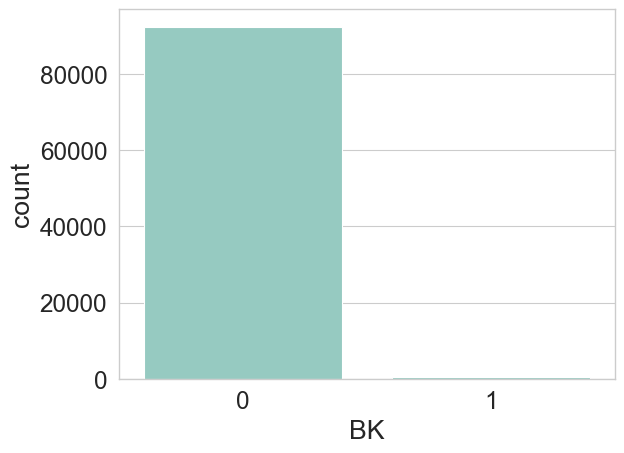

In [14]:
sns.countplot(data = df, x = "BK")
plt.show()

**Nhận xét:**
Biểu đồ minh họa dữ liệu bị mất cân bằng nghiêm trọng. Với nhóm phá sản (`BK = 1`) chỉ chiếm tỉ lệ 0.6% (558 mẫu) cho tổng thể, nếu không xử lý mất cân bằng phù hợp, mô hình có thể đạt độ chính xác giả tạo (high accuracy) nhưng hoàn toàn thất bại trong việc phát hiện rủi ro phá sản.


**Ý nghĩa thực nghiệm:**

* Đây là bài toán *rare-event*, rất phổ biến trong dự đoán phá sản.
* Nếu không xử lý, mô hình sẽ “bỏ qua” nhóm phá sản → đoán toàn 0 vẫn đạt Accuracy cao.

**Hướng xử lý:**

Sau này trong mô hình, nhóm sẽ dùng **SMOTE** (Synthetic Minority Over-sampling Technique) và **ENN** (Edited Nearest Neighbors) để cân bằng dữ liệu.

- SMOTE được dùng trước để tạo thêm dữ liệu lớp thiểu số, giúp cân bằng số lượng.

- ENN được dùng sau để dọn dẹp các mẫu "tổng hợp" bị lỗi hoặc quá sát biên do SMOTE tạo ra.

### 2.4. Kiểm tra phân phối của các đặc trưng

In [15]:
# Tạo DataFrame gồm các biến độc lập để khám phá dữ liệu
df_independent = df.drop(["BK"], axis=1)

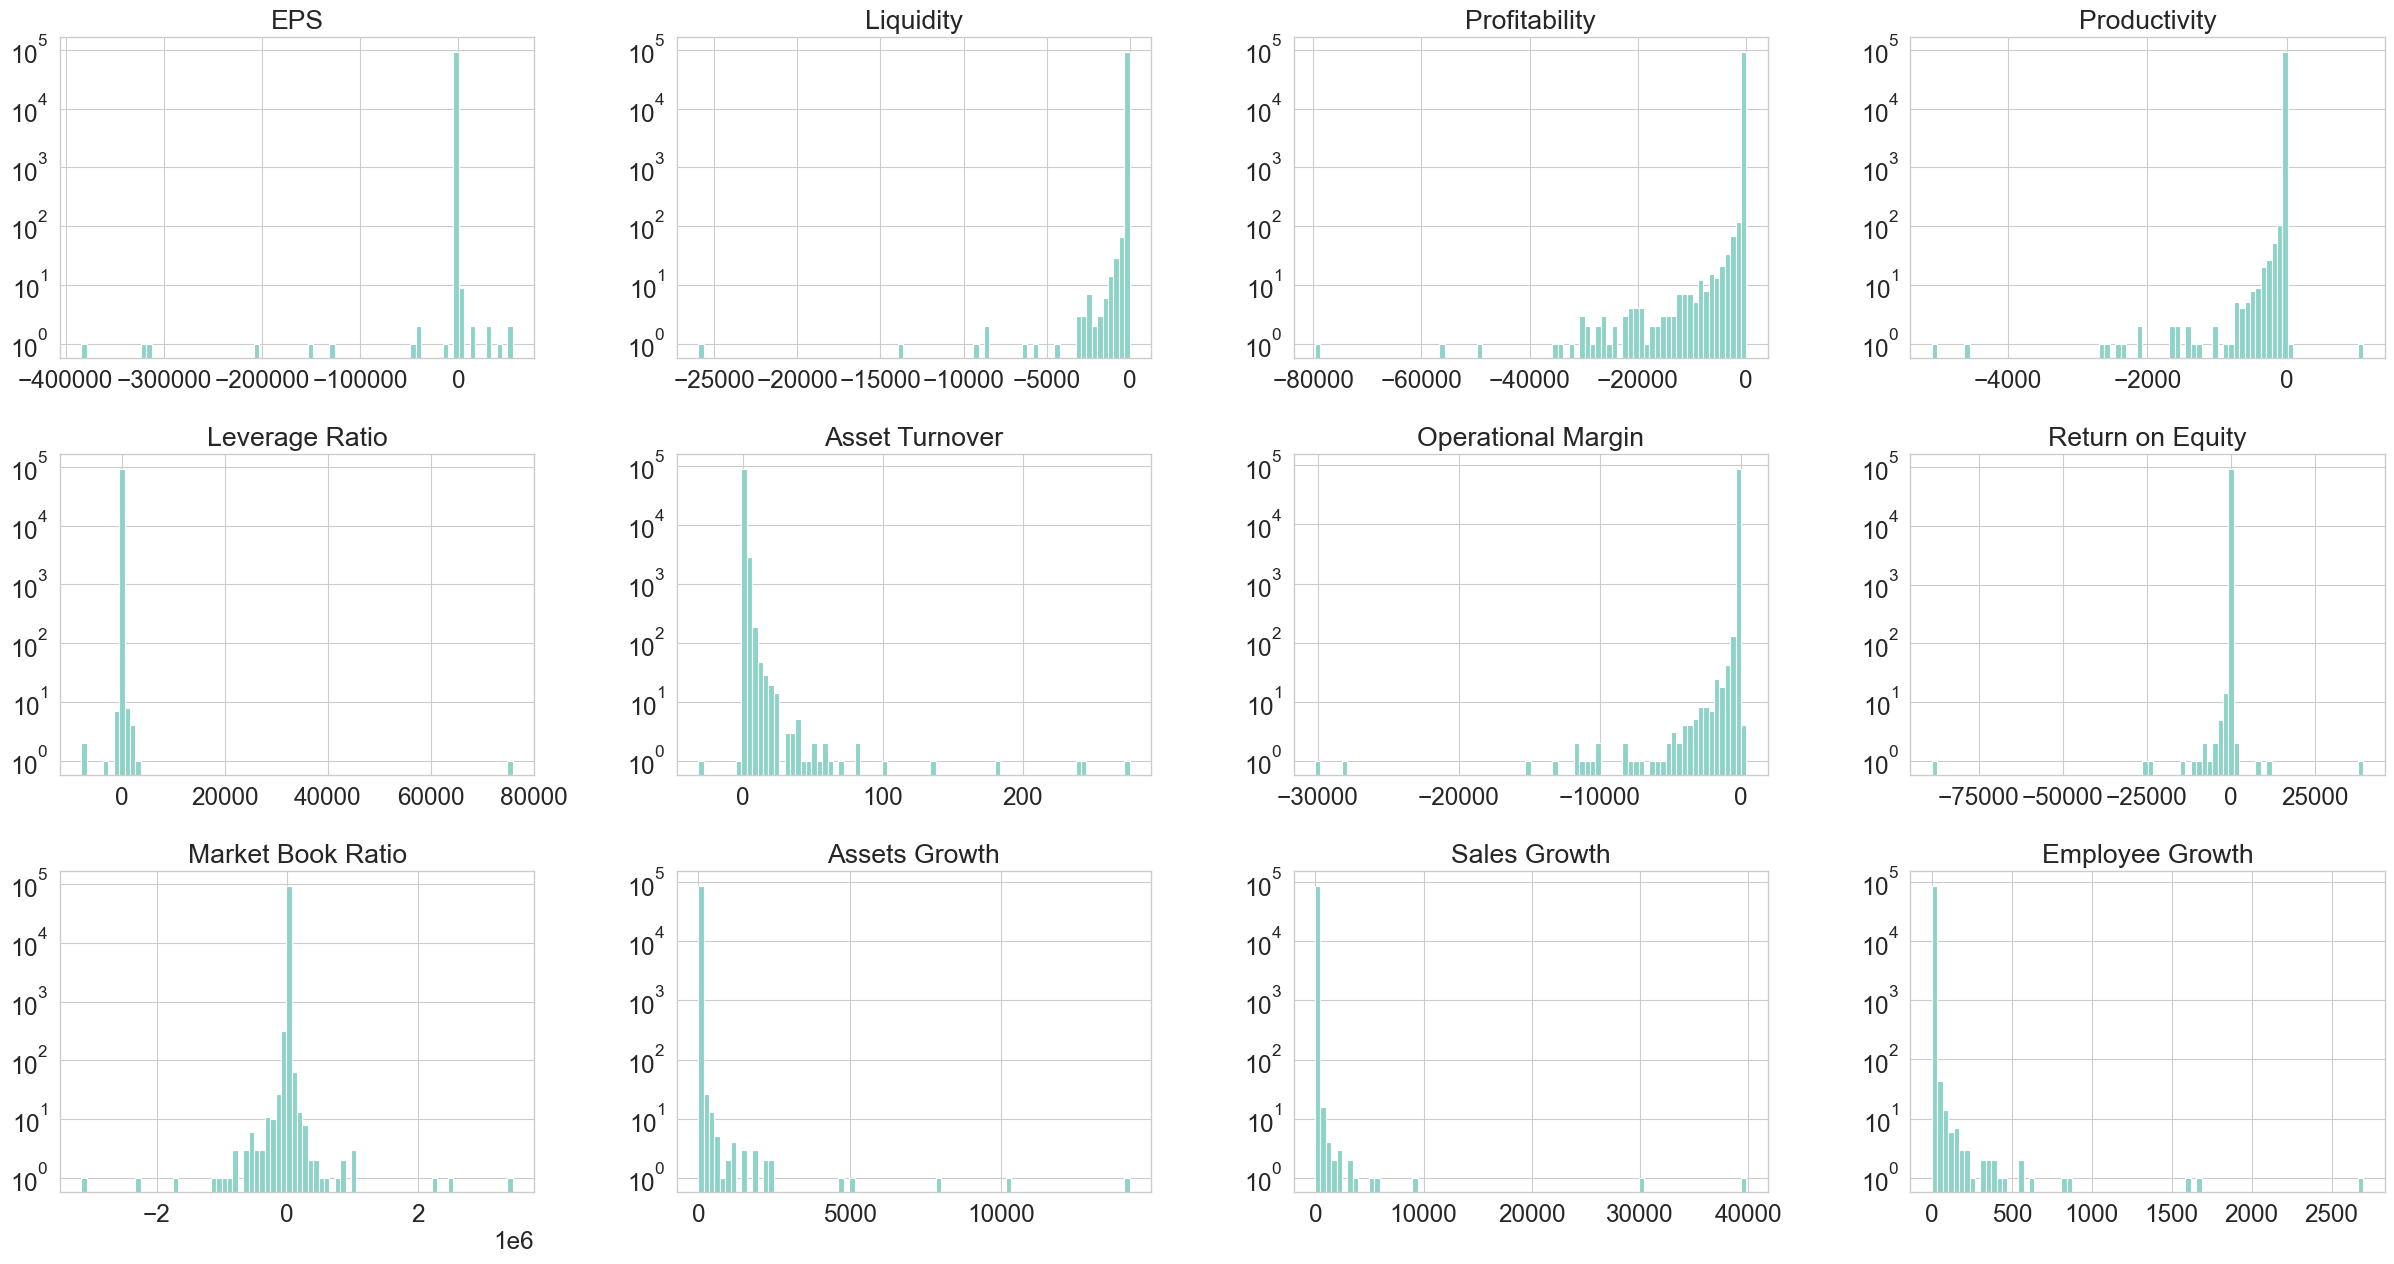

In [16]:
# Hiển thị phân phối của từng đặc trưng trên thang logarit
df.hist(column = df_independent.columns, bins = 80, figsize = (30,15), layout = (3,4), log = True)
plt.show()

**Nhận xét:**
- Đồ thị Histogram cho thấy hầu hết các biến có phân phối không chuẩn với mức độ lệch (**skewness**) cao và xuất hiện nhiều giá trị ngoại lai nằm xa vùng phân phối chính. Đồng thời, một số biến có sự tập trung dữ liệu rất lớn (độ nhọn cao) tại một số khoảng giá trị nhất định.

- Những đặc điểm này phản ánh phân bố không đồng đều, dễ ảnh hưởng đến mô hình, nên ta cần phải xử lý ngoại lai hoặc biến đổi/chuẩn hóa dữ liệu mạnh trước khi đưa vào huấn luyện.

**Hướng xử lý:**

* Sử dụng **RobustScaler** nhằm giảm ảnh hưởng của outlier bằng median & IQR.

### 2.5. Kiểm tra phân phối của các đặc trưng đối với biến mục tiêu

Ta sử dụng box-plot cho các biến định lượng để quan sát các giá trị ngoại lai (outliers).

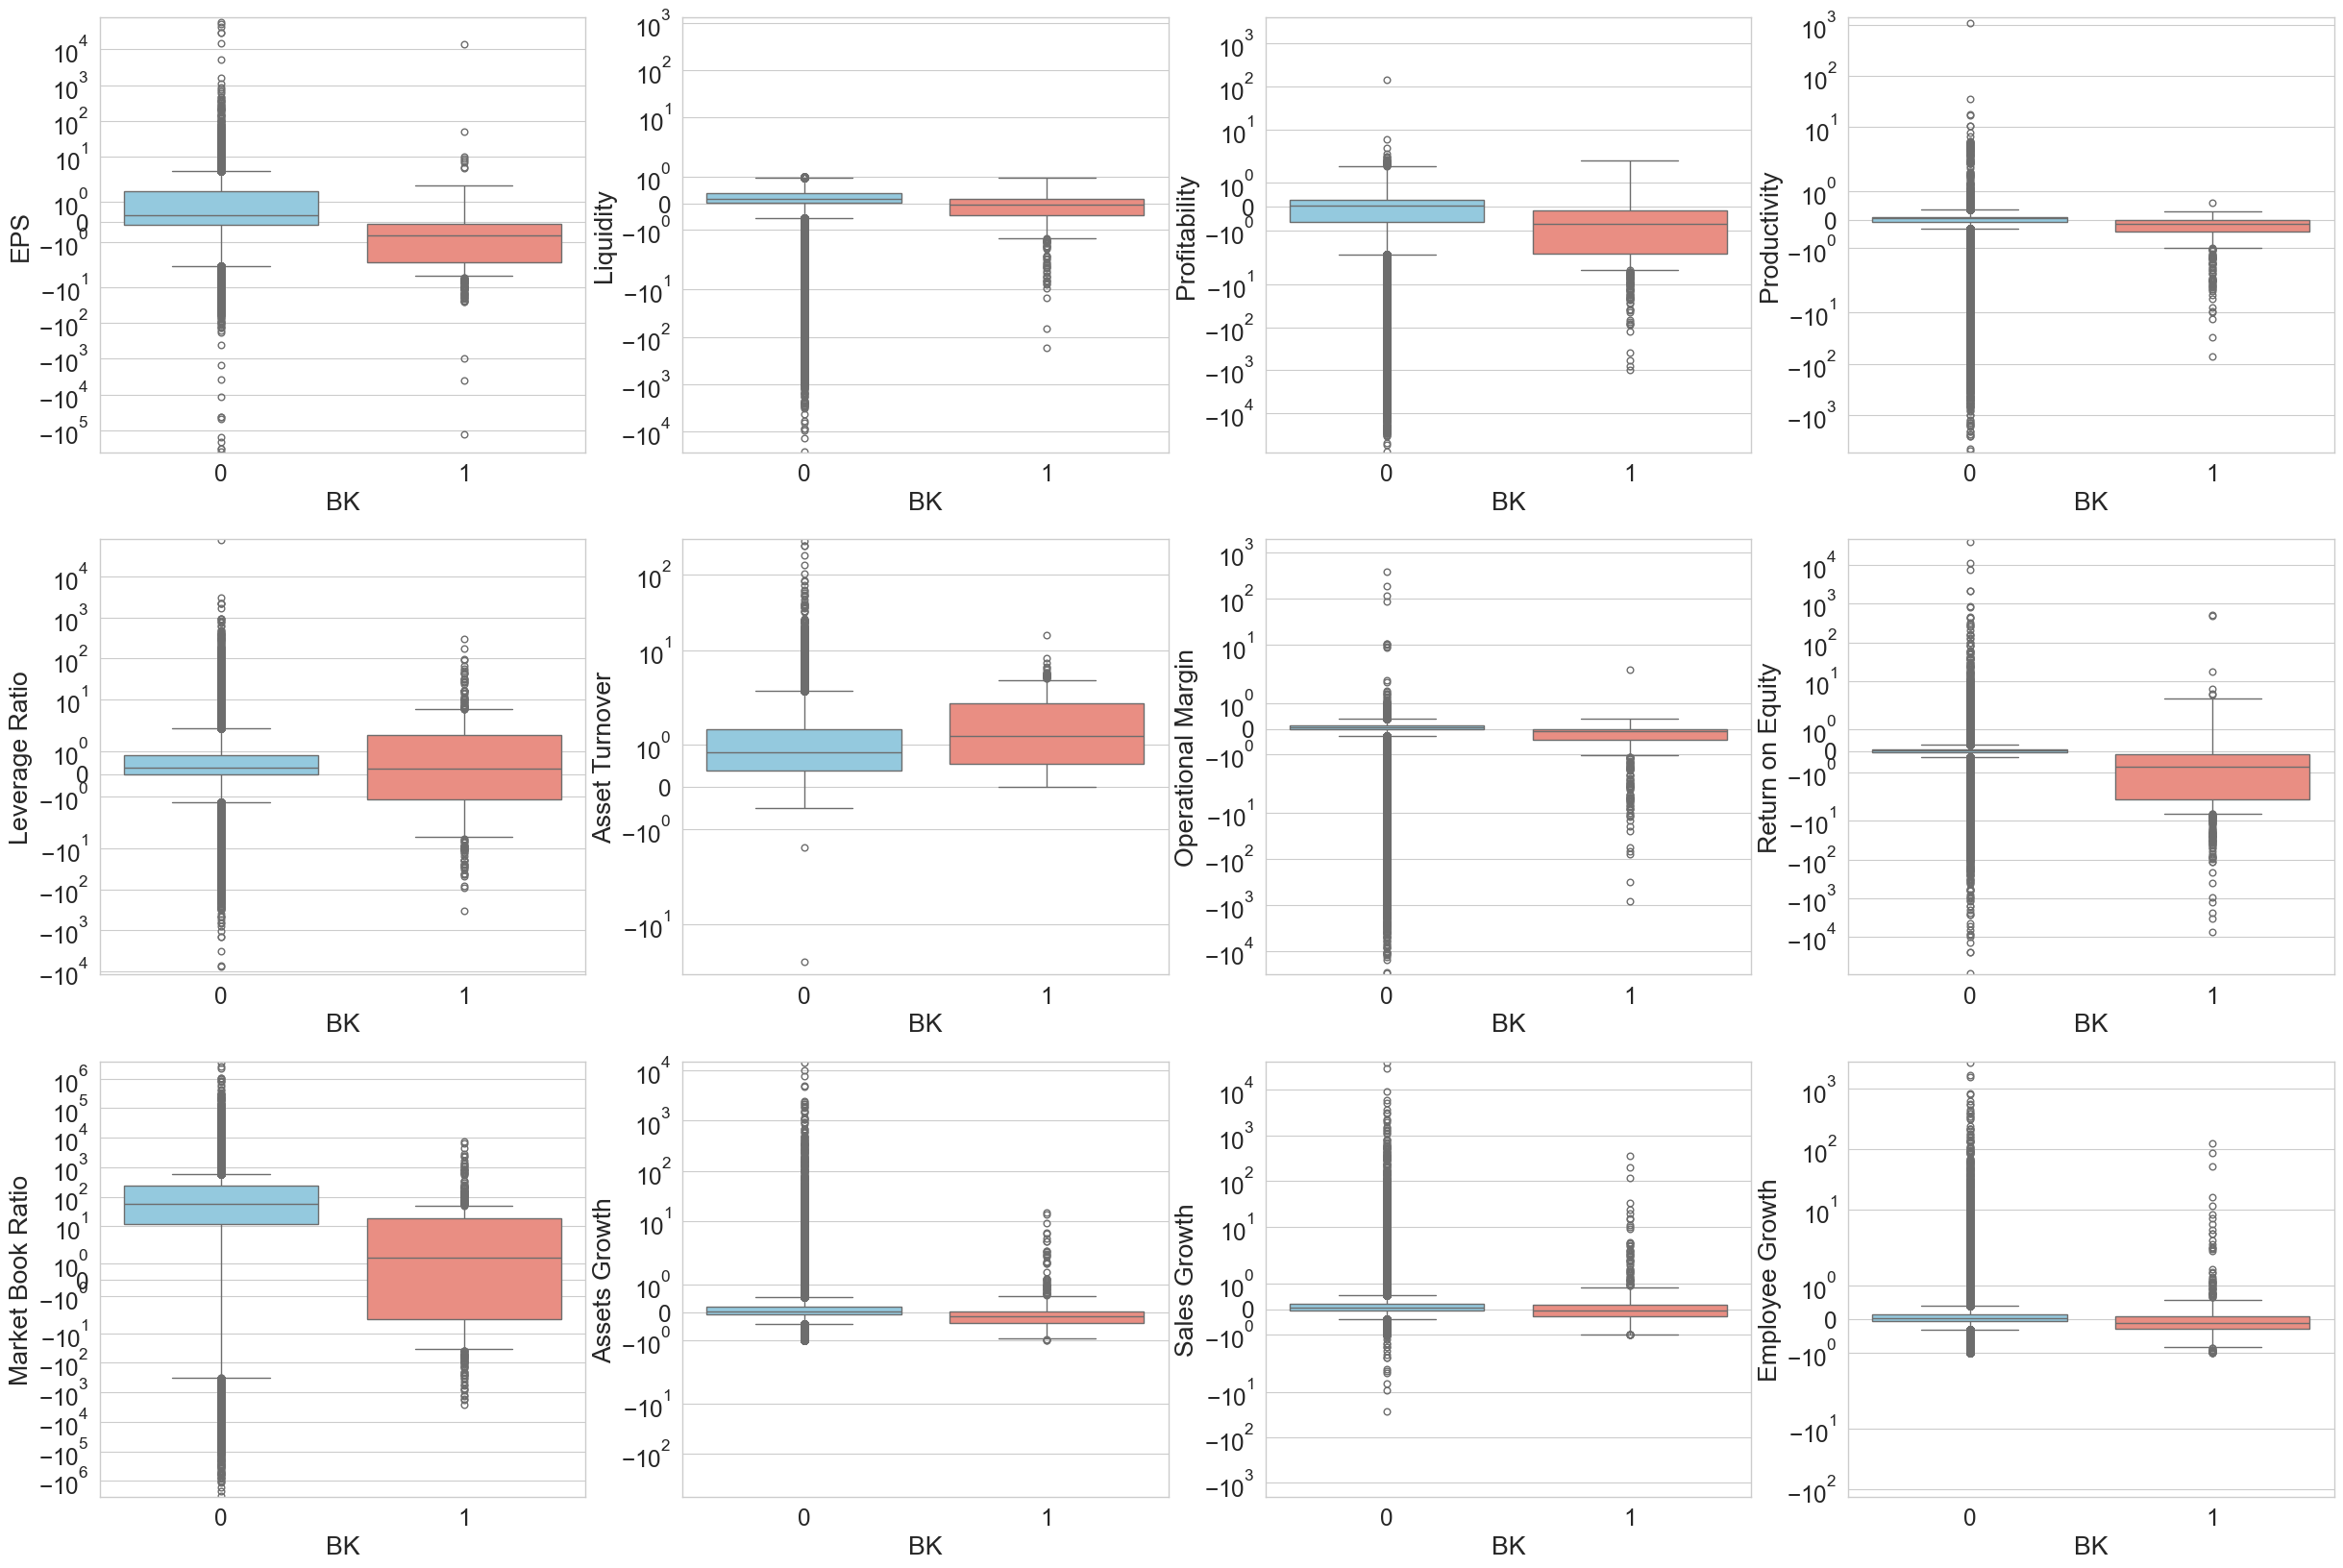

In [17]:
num_cols = df_independent.columns.tolist()
fig,axes = plt.subplots(3,4,figsize=(30,20))
for idx,num_col in enumerate(num_cols):
    row,col = idx//4,idx%4
    g = sns.boxplot(y=num_col,
                    data=df,
                    x='BK',
                    ax=axes[row,col],
                    palette = ["skyblue", "salmon"],
                    hue='BK',# Thêm dòng này để định rõ biến dùng để tô màu
                    legend=False)
    g.set_yscale('symlog')
plt.show()

Ta thấy ngoại lại xuất hiện rất nhiều ở hầu hết tất cả các biến và  thông qua box-plot, tiếp theo ta tìm số lượng ngoại lai của các biến định lượng thông qua IQR.

In [18]:
Q1 = df_independent[num_cols].quantile(0.25)
Q3 = df_independent[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Xác định ngoại lai cho toàn bộ dataframe cùng lúc
outliers = ((df_independent[num_cols] < (Q1 - 1.5 * IQR)) | (df_independent[num_cols] > (Q3 + 1.5 * IQR)))

# Đếm tổng theo từng cột
all_outlier_counts = outliers.sum()

print("Số lượng ngoại lai (IQR 1.5x) cho tất cả các cột:")
print(all_outlier_counts)

Số lượng ngoại lai (IQR 1.5x) cho tất cả các cột:
EPS                    8396
Liquidity              4467
Profitability         14150
Productivity          13229
Leverage Ratio        10342
Asset Turnover         3706
Operational Margin    15577
Return on Equity      13064
Market Book Ratio     15997
Assets Growth         11995
Sales Growth          12436
Employee Growth       12673
dtype: int64


**Nhận xét:**
- Số lượng ngoại lai của các biến định lượng là rất lớn so với tổng thể (chiếm khoảng 12% đến 17%), cho thấy phân phối của dữ liệu có đuôi dày và có độ biến động rất cao. Điều này phản ánh đặc thù biến động mạnh của dữ liệu tài chính doanh nghiệp và ta cần có các biện pháp để xử lí các giá trị ngoại lai để mô hình không bị ảnh hưởng nặng nề.

- Các doanh nghiệp phá sản thường có:

  * Tỷ lệ nợ cao hơn
  * ROE/ROA thấp, thậm chí âm nặng
  * Market ratio thấp

**Điểm quan trọng:** Nhiều “outlier” chính là **đặc trưng của phá sản**, không thể loại bỏ.

**Hướng xử lý:** Không xóa toàn bộ outlier mà chỉ khảo sát ảnh hưởng.

### 2.6. Kiểm tra tương quan giữa các đặc trưng

Ta sử dụng bản đồ nhiệt tương quan (heat-map) để kiểm tra mối tương quan giữa các biến với nhau.

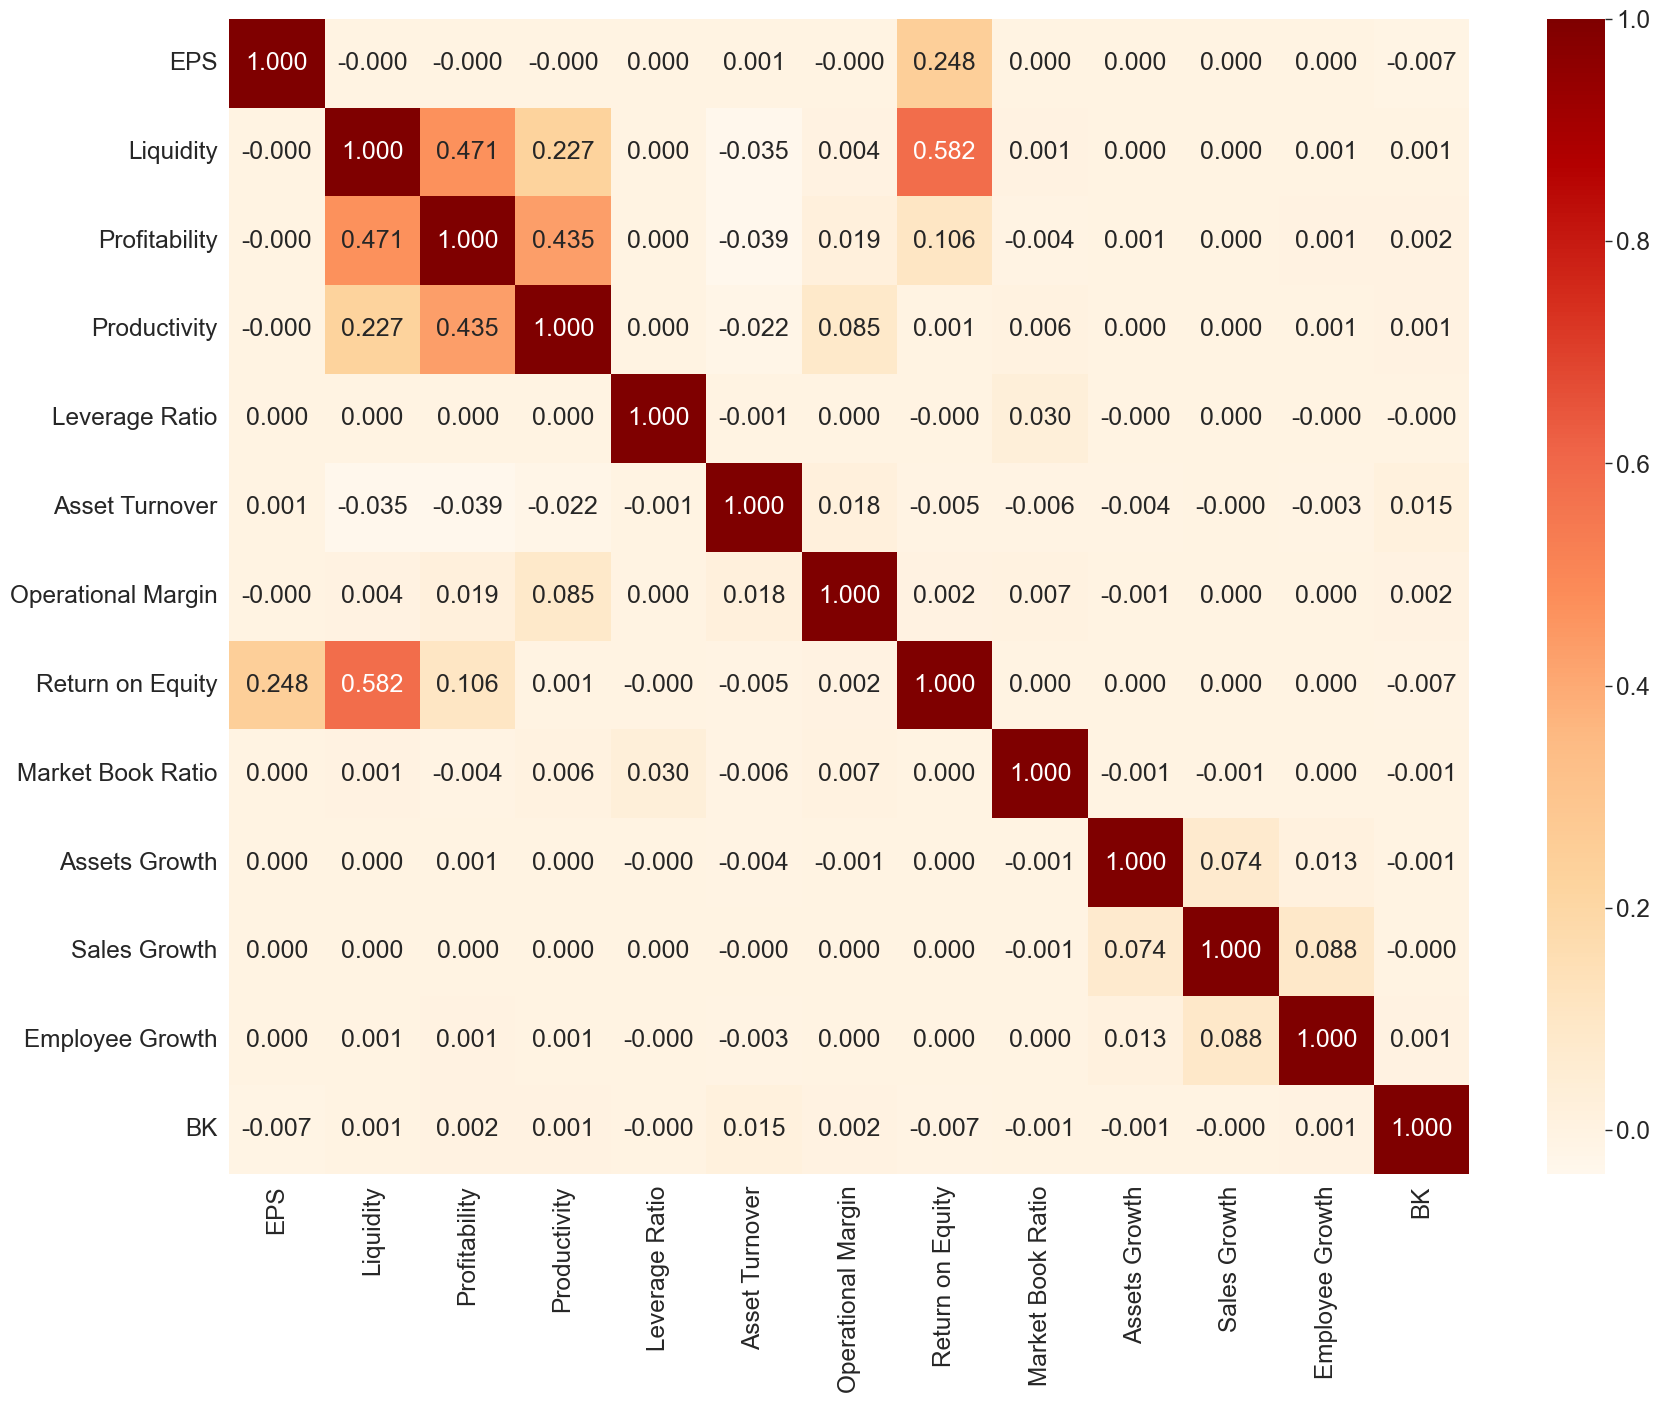

In [19]:
# Tạo bản đồ nhiệt tương quan
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot = True, fmt = ".3f", annot_kws={"fontsize":18}, cmap='OrRd')
plt.show()

- Heatmap tương quan cho thấy không có biến nào tương quan cao (chỉ một vài cặp ~0.58, còn lại < 0.5), cho thấy các biến đều mang thông tin độc lập.

- Các hệ số này đều nằm dưới ngưỡng cảnh báo thường dùng (**lớn hơn 0.7 hoặc 0.8**). Điều này cho thấy ta không cần thực hiện loại bỏ biến do hiện tượng đa cộng tuyến. Việc giữ lại toàn bộ các biến giúp mô hình khai thác tối đa thông tin đa chiều từ dữ liệu.

### 2.7. Kiểm tra giá trị trùng lặp

In [20]:
# Kiểm tra các bản ghi trùng lặp trong mẫu dữ liệu
df.duplicated().value_counts()

False    92845
True        27
Name: count, dtype: int64

In [21]:
# Loại bỏ các bản ghi trùng lặp
df.drop_duplicates(inplace=True)

In [22]:
# Kiểm tra lại DataFrame xem còn bản ghi trùng lặp không
df.duplicated().value_counts()

False    92845
Name: count, dtype: int64

In [23]:
# Kiểm tra xem ta mất đi bao nhiêu trường hợp phá sản khi loại bỏ các bộ dữ liệu trùng lặp
df["BK"].value_counts()

BK
0    92287
1      558
Name: count, dtype: int64

**Nhận xét:** Sau khi thực hiện loại bỏ các quan sát trùng lặp, vẫn giữ đúng **558 mẫu phá sản**. Các trường hợp phá sản (`BK = 1`) vẫn được giữ nguyên.

### 2.8. Kiểm tra giá trị ngoại lai

Đầu tiên, ta kiểm tra ảnh hưởng của việc loại bỏ giá trị ngoại lai trên tập dữ liệu

In [24]:
# Định nghĩa một hàm để xóa theo dòng các bản ghi có ít nhất 1 giá trị ngoại lai dựa trên danh sách các cột

def remove_outliers(df,cols,distance = 1.5):
    # Tính các điểm tứ phân vị và IQR
    Q1 = df[cols].quantile(0.25) # Nhận giá trị trong khoảng (0,1).
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1

    # condition là một Series Boolean, đánh dấu dòng nào không chứa giá trị ngoại lai trong các cột cols.
    condition = ~((df[cols] < (Q1 - distance * IQR)) | (df[cols] > (Q3 + distance * IQR))).any(axis=1)

    # Lọc DataFrame dựa trên condition
    filtered_df = df[condition]

    return filtered_df

In [25]:
# Tạo danh sách các biến độc lập
independent_variables = df.columns[:-1].tolist()

In [26]:
# Tạo một DataFrame mới không chứa giá trị ngoại lai ở bất kỳ bản ghi nào
df_noOutliers = remove_outliers(df,independent_variables,3)
df_noOutliers.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1.5800,0.3600,0.1800,0.1300,1.3300,1.7700,0.0700,0.1500,2.2200,NaN,NaN,NaN,0
1,1.4100,0.3600,0.1900,0.1200,1.3100,1.5900,0.0700,0.1300,2.4100,0.1263,0.0143,0.0402,0
2,0.3100,0.3200,0.1300,0.0800,1.0300,1.5500,0.0500,0.0400,2.5600,0.3681,0.3279,0.5665,0


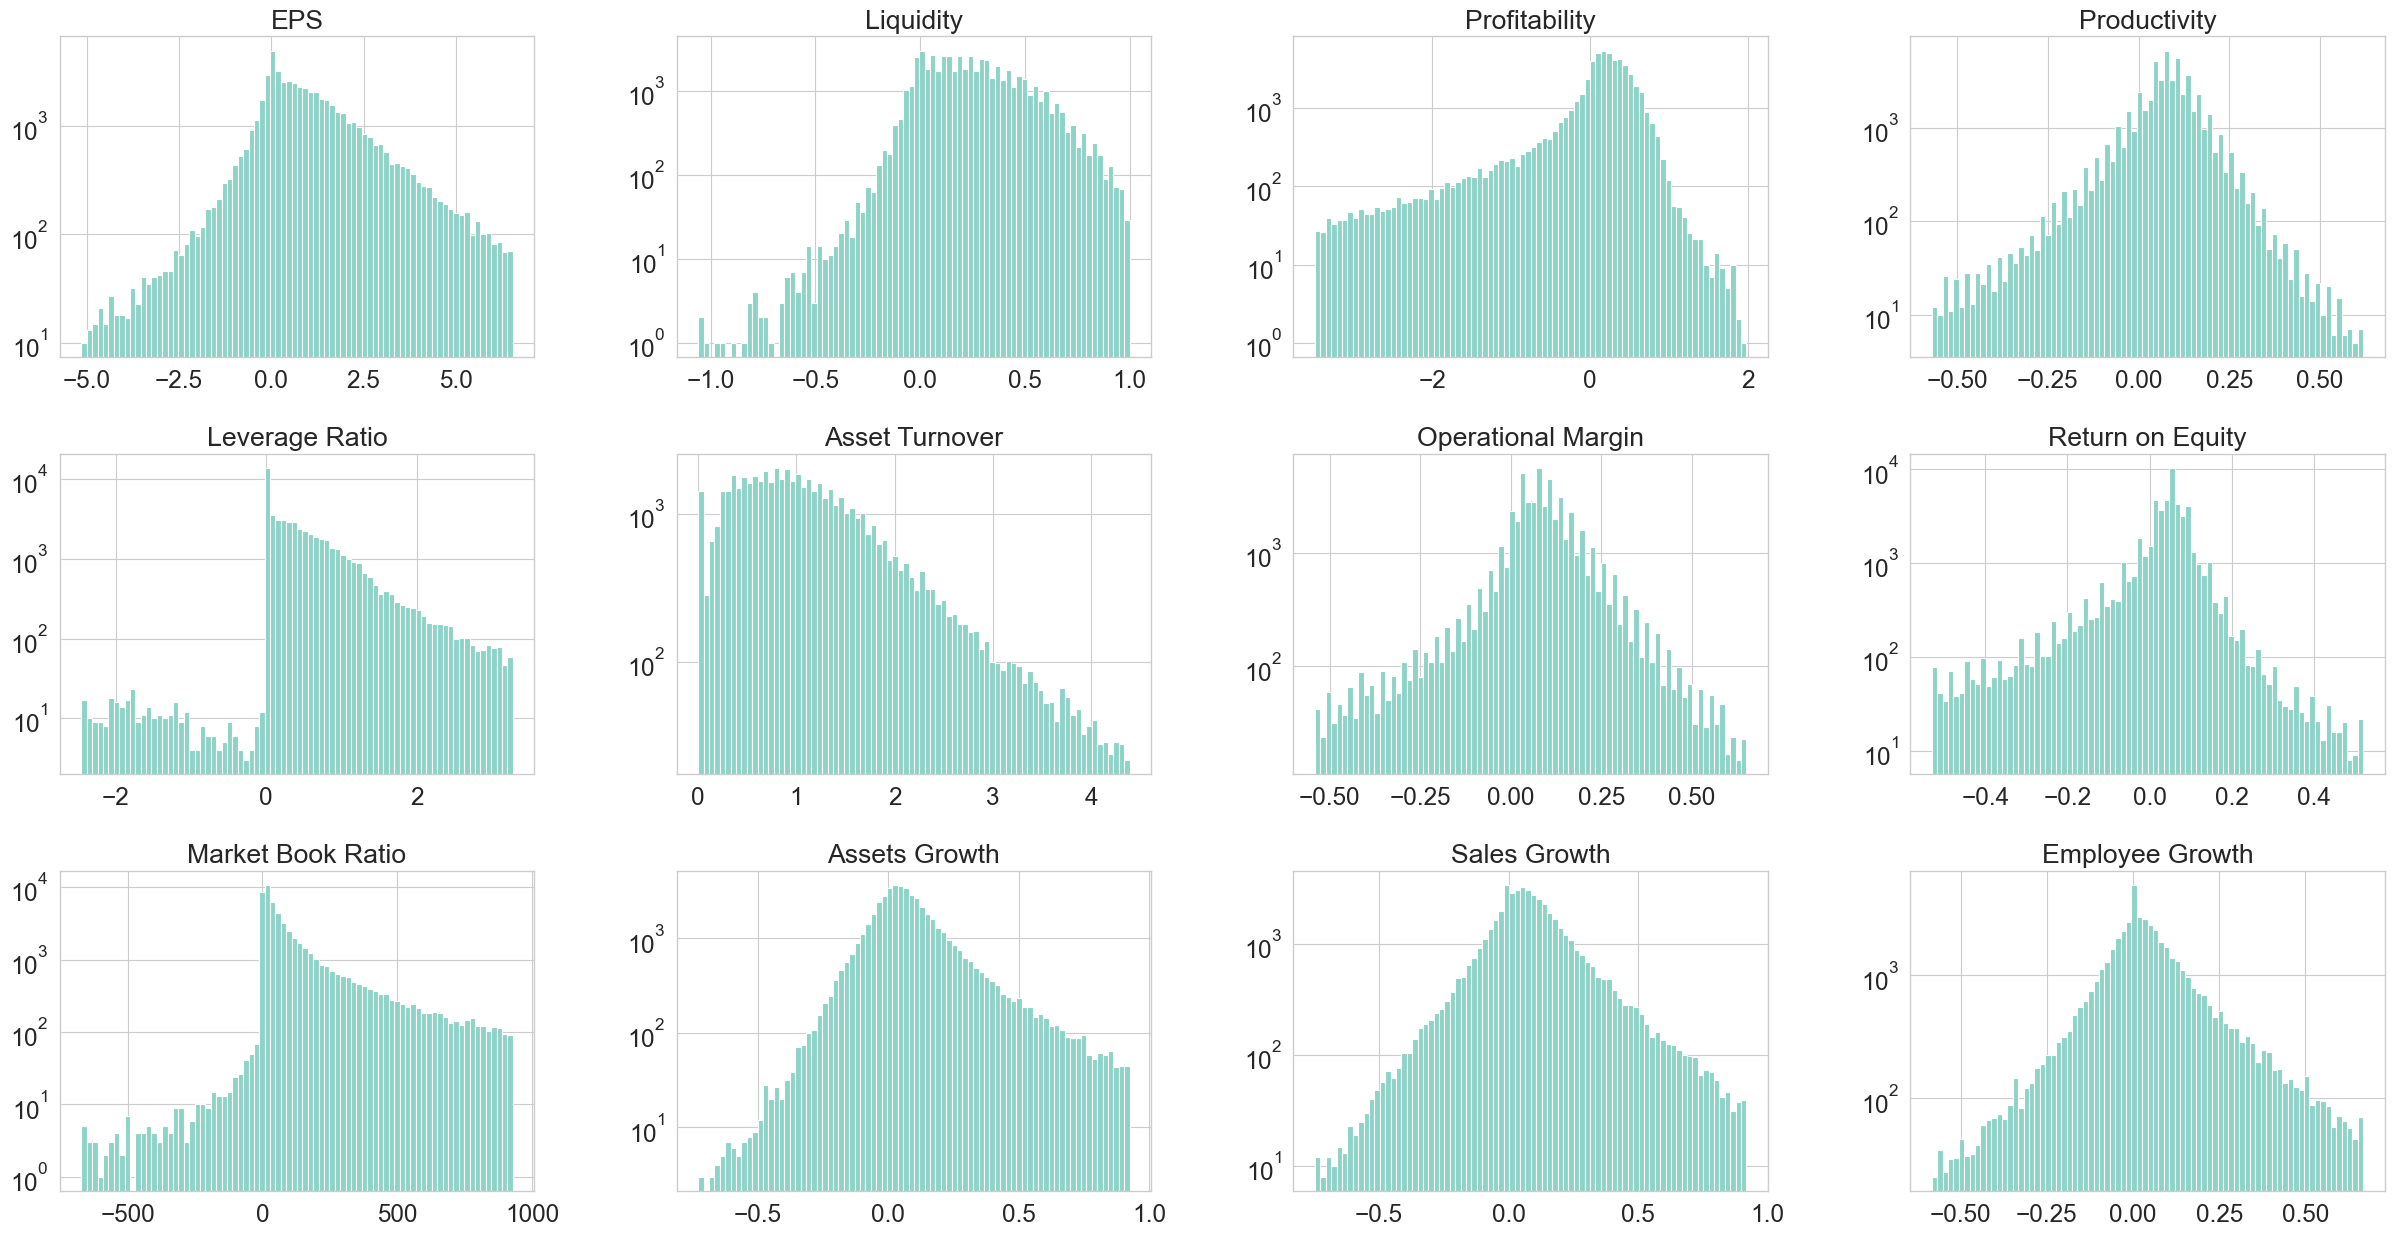

In [27]:
# Hiển thị phân phối của từng đặc trưng trên thang logarit
df_noOutliers.hist(column = df_independent.columns, bins = 80, figsize = (30,15), layout = (3,4), log = True)
plt.show()

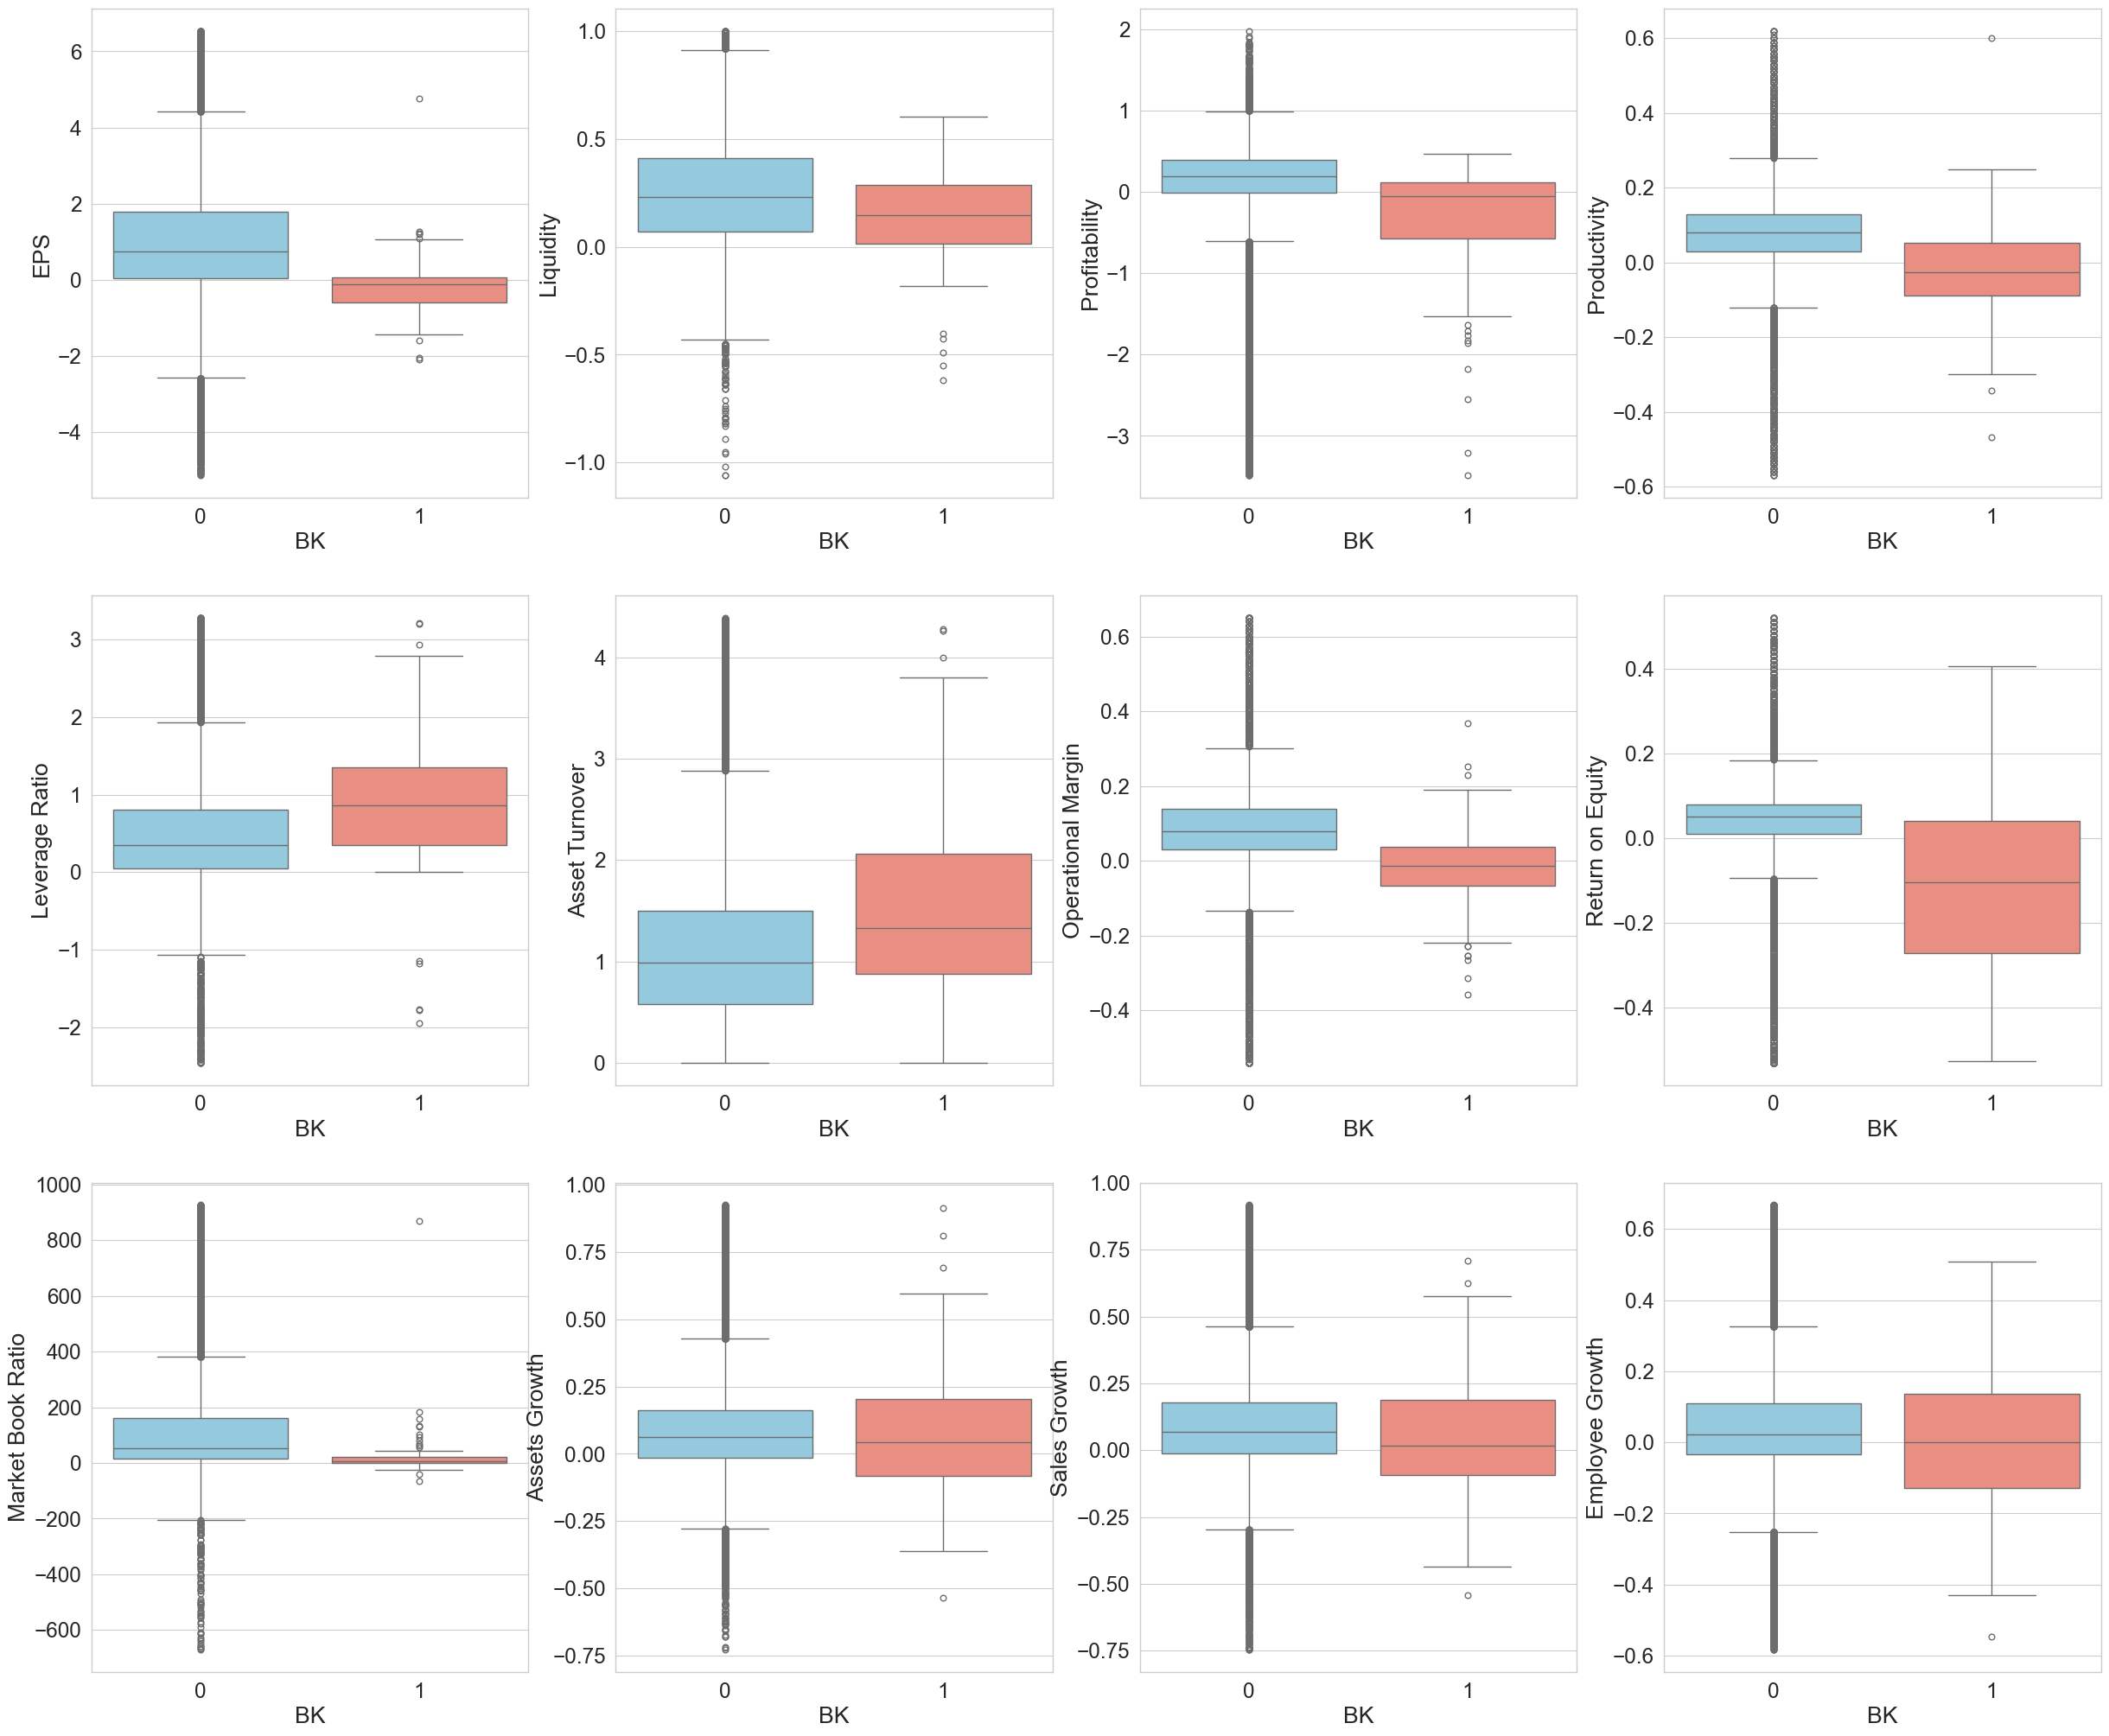

In [28]:
num_cols = df_independent.columns.tolist()
fig,axes = plt.subplots(3,4,figsize=(30,25))
for idx,num_col in enumerate(num_cols):
    row,col = idx//4,idx%4
    g = sns.boxplot(y=num_col,
                    data=df_noOutliers,
                    x='BK',
                    ax=axes[row,col],
                    palette = ["skyblue", "salmon"],
                    hue="BK",
                    legend=False)
plt.show()

In [29]:
df_noOutliers.shape

(54239, 13)

In [30]:
df_noOutliers["BK"].value_counts()
# Mất đáng kể các trường hợp phá sản (sự kiện hiếm)

BK
0    54157
1       82
Name: count, dtype: int64

Tỷ lệ giá trị ngoại lai chiếm tới 12-17% tổng thể dữ liệu, việc loại bỏ hoàn toàn các mẫu này sẽ dẫn đến mất mát thông tin nghiêm trọng, làm giảm đáng kể kích thước mẫu và có thể xóa đi các đặc trưng quan trọng của những doanh nghiệp có tình hình tài chính đặc biệt (rất tốt hoặc rất xấu). Vì vậy ta chọn giữ lại toàn bộ các quan sát này trong DataFrame thay vì xóa bỏ.

Để giảm thiểu tác động của các giá trị ngoại lại và cực ngoại lai lên mô hình mà không cần xóa dữ liệu, ta kiểm tra ảnh hưởng của việc xử lý giá trị ngoại lai trên tập dữ liệu bằng **phương pháp Winsorization** (thay giá trị cực đoan bằng giá trị gần nhất trong ngưỡng giới hạn) để đảm bảo tính toàn vẹn của dữ liệu.

Ta xây dựng hàm xử lý ngoại lai bằng **kỹ thuật Winsorization**, hàm này có chức năng thay thế các giá trị nằm ngoài khoảng phân vị bằng các giá trị biên tương ứng. Đối với dữ liệu tài chính nhiều nhiễu, ta thường đặt ngưỡng dưới 5% và trên 95%.

In [31]:
# Tạo một hàm để xử lý Winsorize cho từng cột của DataFrame
def winsorize_df(df,lower_limit, upper_limit, columns = df.columns):
    df_winsor = df.copy()
    for col in columns:
        df_winsor[col] = winsorize(df[col], limits = [lower_limit, upper_limit], inplace = False)
    return df_winsor

In [32]:
# Kiểm thử hàm Winsorize trên dữ liệu
test_winsor = winsorize(df['EPS'],limits = [0.01,0.01],inplace = False)

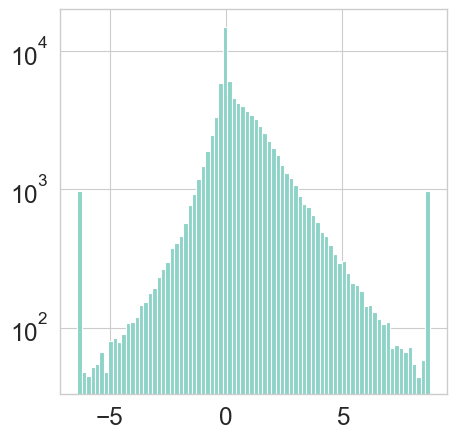

In [33]:
plt.subplots(figsize = (5,5))
plt.hist(test_winsor,bins = 80,log = True)
plt.show()

Ta áp dụng Winsorize (5%-95%) trên toàn bộ các biến định tính để giảm ảnh hưởng của các giá trị ngoại lai.

In [34]:
df_winsorized = winsorize_df(df,0.05,0.05,independent_variables)

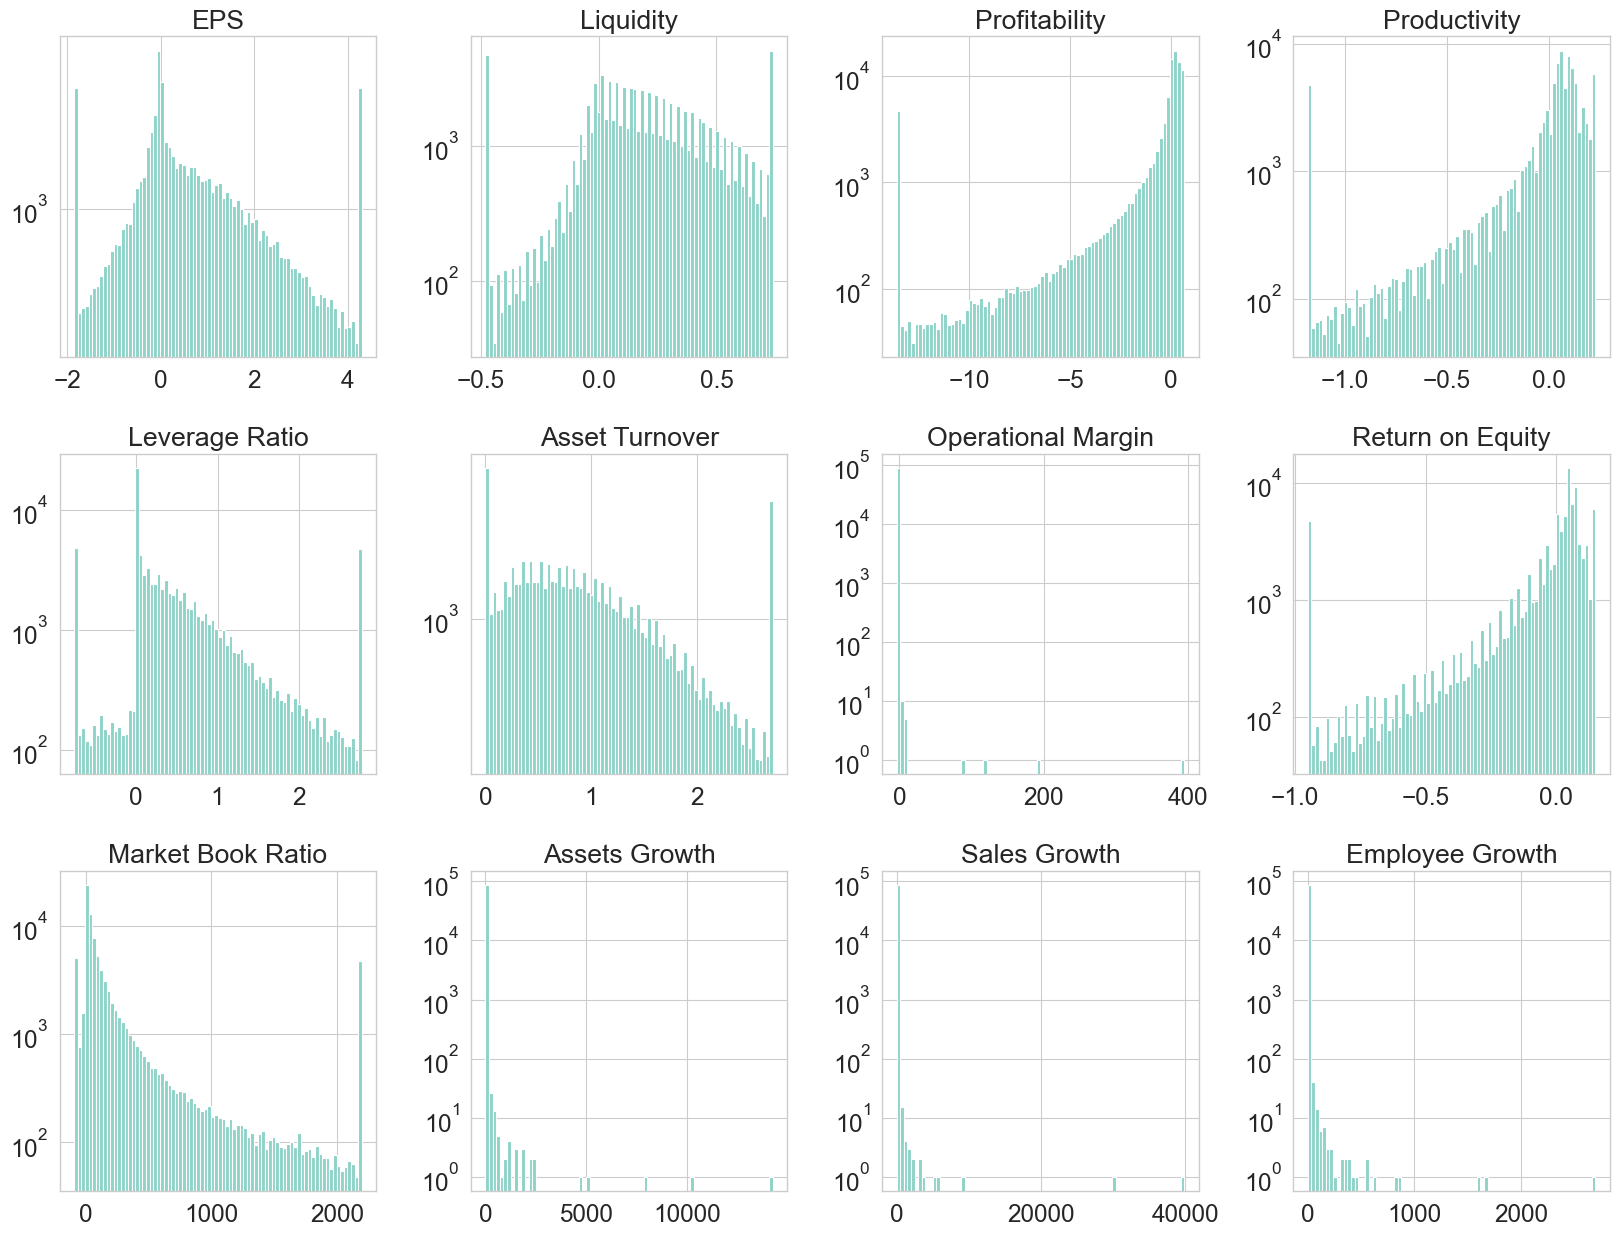

In [35]:
df_winsorized.hist(column = df_independent.columns, bins = 80, figsize = (20,15), layout = (3,4), log = True)
plt.show()

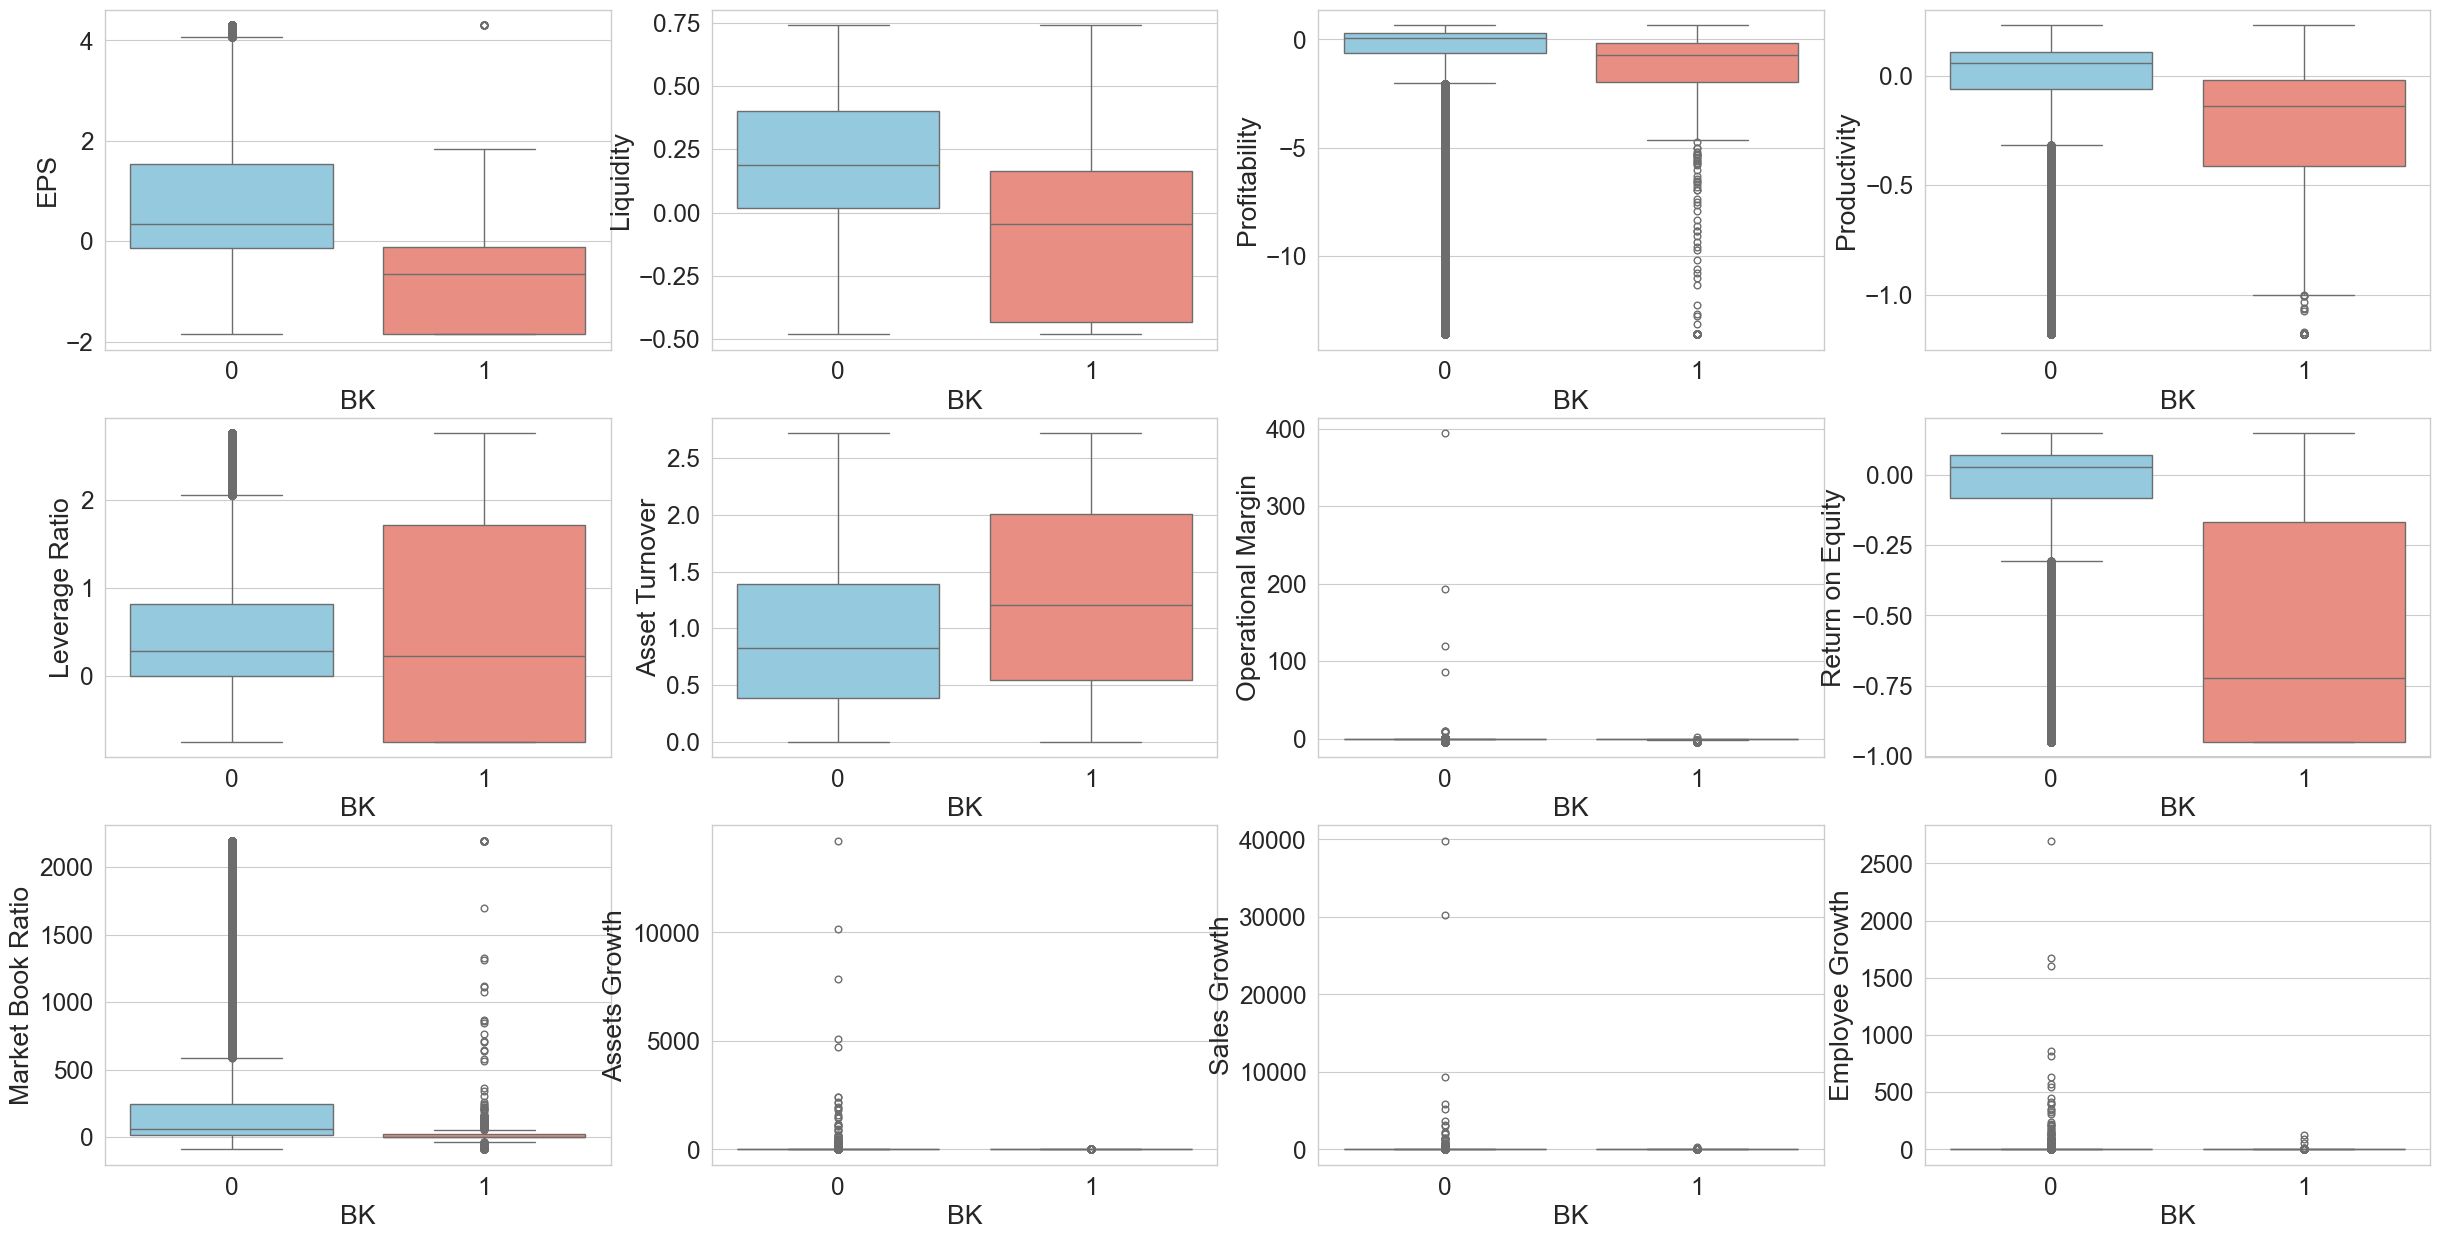

In [36]:
num_cols = df_independent.columns.tolist()
fig,axes = plt.subplots(3,4,figsize=(30,15))
for idx,num_col in enumerate(num_cols):
    row,col = idx//4,idx%4
    g = sns.boxplot(y=num_col,
                    data=df_winsorized,
                    x='BK',
                    ax=axes[row,col],
                    palette = ["skyblue", "salmon"],
                    hue="BK",
                    legend=False)
plt.show()

Quan sát các biểu đồ Histogram và Boxplot sau khi áp dụng kỹ thuật Winsorization với cắt ngưỡng 5% - 95%, ta thấy được sự thay đổi rõ rệt so với phân phối của dữ liệu ban đầu.

- Các cực ngoại lại (extreme outliers) đã biến mất và dù còn một số ngoại lai sau khi **Winsorize**, biểu đồ box-plot đã có thể quan sát rõ ràng hơn về cấu trúc của vùng tứ phân vị (IQR).

- Mặc dù Winsorization không biến đổi dữ liệu hoàn toàn thành phân phối chuẩn, nhưng việc loại bỏ phần đuôi dài do các ngoại lai và cực ngoại lai gây ra đã giúp phân phối trở nên gọn gàng hơn, tập trung hơn vào vùng trung tâm.


In [37]:
df.describe()

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
count,92840.0000,92598.0000,92598.0000,92598.0000,92819.0000,92598.0000,87288.0000,92837.0000,92788.0000,86152.0000,86152.0000,85843.0000,92845.0000
mean,-14.4664,-2.6320,-29.5459,-1.2233,1.3454,1.0538,-7.9180,-2.1130,358.5937,1.2943,1.9005,0.3434,0.0060
std,2195.7865,121.6286,677.3292,35.8908,253.0749,2.1162,214.4932,352.6482,26067.4293,73.7777,177.6522,14.0757,0.0773
min,-384000.0000,-25968.5200,-79682.0000,-5093.0000,-7811.0000,-31.5900,-30175.7000,-88875.1400,-3151500.0000,-1.0000,-27.4310,-1.0000,0.0000
25%,-0.1400,0.0200,-0.6400,-0.0600,0.0000,0.3900,-0.0300,-0.0800,11.2000,-0.0526,-0.0335,-0.0481,0.0000
50%,0.3300,0.1900,0.0700,0.0600,0.2800,0.8300,0.0600,0.0300,58.3050,0.0519,0.0597,0.0172,0.0000
75%,1.5300,0.4000,0.3100,0.1100,0.8200,1.3900,0.1400,0.0700,240.1700,0.1921,0.2043,0.1310,0.0000
max,55339.0000,1.0000,140.5800,1102.0000,75970.3800,276.3800,394.4700,39500.0000,3455419.3300,14231.0000,39850.0000,2699.0000,1.0000


In [38]:
df_winsorized.describe()

C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\PC\AppData\Roaming\Python\Pytho

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
count,92845.0000,92845.0000,92845.0000,92845.0000,92845.0000,92845.0000,87288.0000,92845.0000,92845.0000,86152.0000,86152.0000,85843.0000,92845.0000
mean,0.7245,0.2035,-1.2086,-0.0604,0.5254,0.9684,-0.2260,-0.0716,287.0308,1.3063,1.9166,0.3561,0.0060
std,1.5146,0.2921,3.4357,0.3391,0.8036,0.7418,1.8452,0.2669,560.1953,73.7774,177.6520,14.0749,0.0773
min,-1.8500,-0.4800,-13.5900,-1.1800,-0.7500,0.0000,-3.7600,-0.9500,-92.4000,-0.3701,-0.3944,-0.3214,0.0000
25%,-0.1400,0.0200,-0.6300,-0.0600,0.0000,0.3900,-0.0300,-0.0800,11.2100,-0.0526,-0.0335,-0.0481,0.0000
50%,0.3300,0.1900,0.0700,0.0600,0.2800,0.8300,0.0600,0.0300,58.4100,0.0519,0.0597,0.0172,0.0000
75%,1.5300,0.4000,0.3100,0.1100,0.8200,1.3900,0.1400,0.0700,241.0300,0.1921,0.2043,0.1310,0.0000
max,4.3000,0.7400,0.6500,0.2300,2.7600,2.7200,394.4700,0.1500,2196.7000,14231.0000,39850.0000,2699.0000,1.0000


In [39]:
df_winsorized.shape
# Kích thước không thay đổi so với dữ liệu
# ban đầu (sau bước loại giá trị trùng lặp)

(92845, 13)

Bảng tóm tắt các chỉ số thống kê sau xử lý **Winsorize** cho thấy dữ liệu đã đạt được sự ổn định cần thiết. Các đặc trưng tài chính đã được đưa về ngưỡng an toàn. Mặc dù dữ liệu có thể vẫn chưa tuân theo phân phối chuẩn, nhưng việc loại bỏ các cực ngoại lai sẽ giúp các thuật toán học máy hoạt động hiệu quả và hội tụ nhanh hơn.

$⇒$ Phương pháp **Winsorize** tỏ ra tương đối ổn trong việc xử lý giá trị ngoại lai, đây sẽ là phương pháp ta sử dụng trong phần tiền xử lý dữ liệu.

### 2.9. Kiểm tra các giá trị bị thiếu

Đầu tiên, ta kiểm tra các giá trị bị thiếu trên toàn bộ tập dữ liệu.

In [40]:
# Định nghĩa một hàm để kiểm tra dữ liệu bị thiếu
def checkmissing_df(df,index_name = ""):
    count_missing = df.isnull().sum()
    percent_missing = count_missing * 100 / len(df)
    missing_value_df = pd.DataFrame({'counts_missing': count_missing,'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True, ascending = False)
    missing_value_df.index.name = index_name

    return missing_value_df

In [41]:
# Kiểm tra số lượng và tỉ lệ dữ liệu bị thiếu
missingsamples_df = checkmissing_df(df,index_name = "Columns_All")
missingsamples_df

,counts_missing,percent_missing
Columns_All,,
Employee Growth,7002,7.5416
Assets Growth,6693,7.2088
Sales Growth,6693,7.2088
Operational Margin,5557,5.9852
Liquidity,247,0.2660
Asset Turnover,247,0.2660
Productivity,247,0.2660
Profitability,247,0.2660
Market Book Ratio,57,0.0614


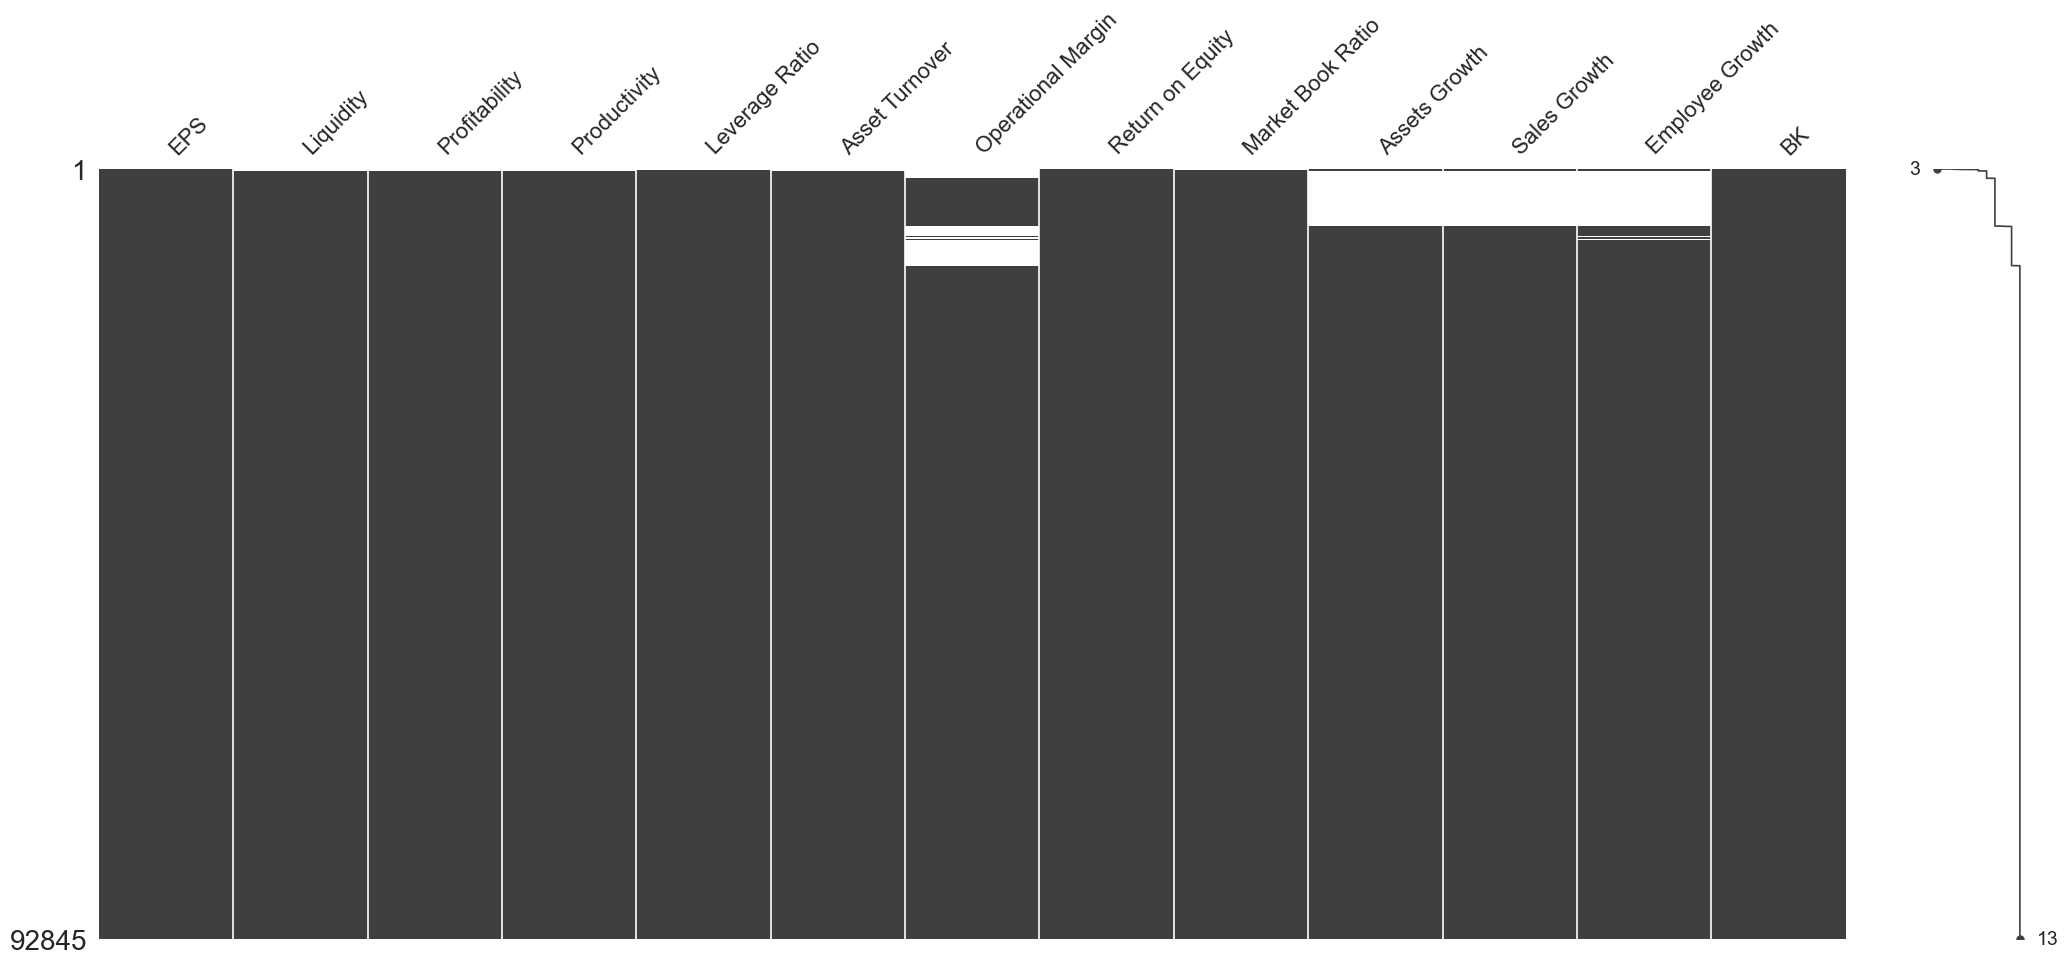

In [42]:
# Trực quan hóa để xem có các khối dữ liệu bị thiếu cùng nhau hay không
msno.matrix(df,sort = "ascending")
plt.show()

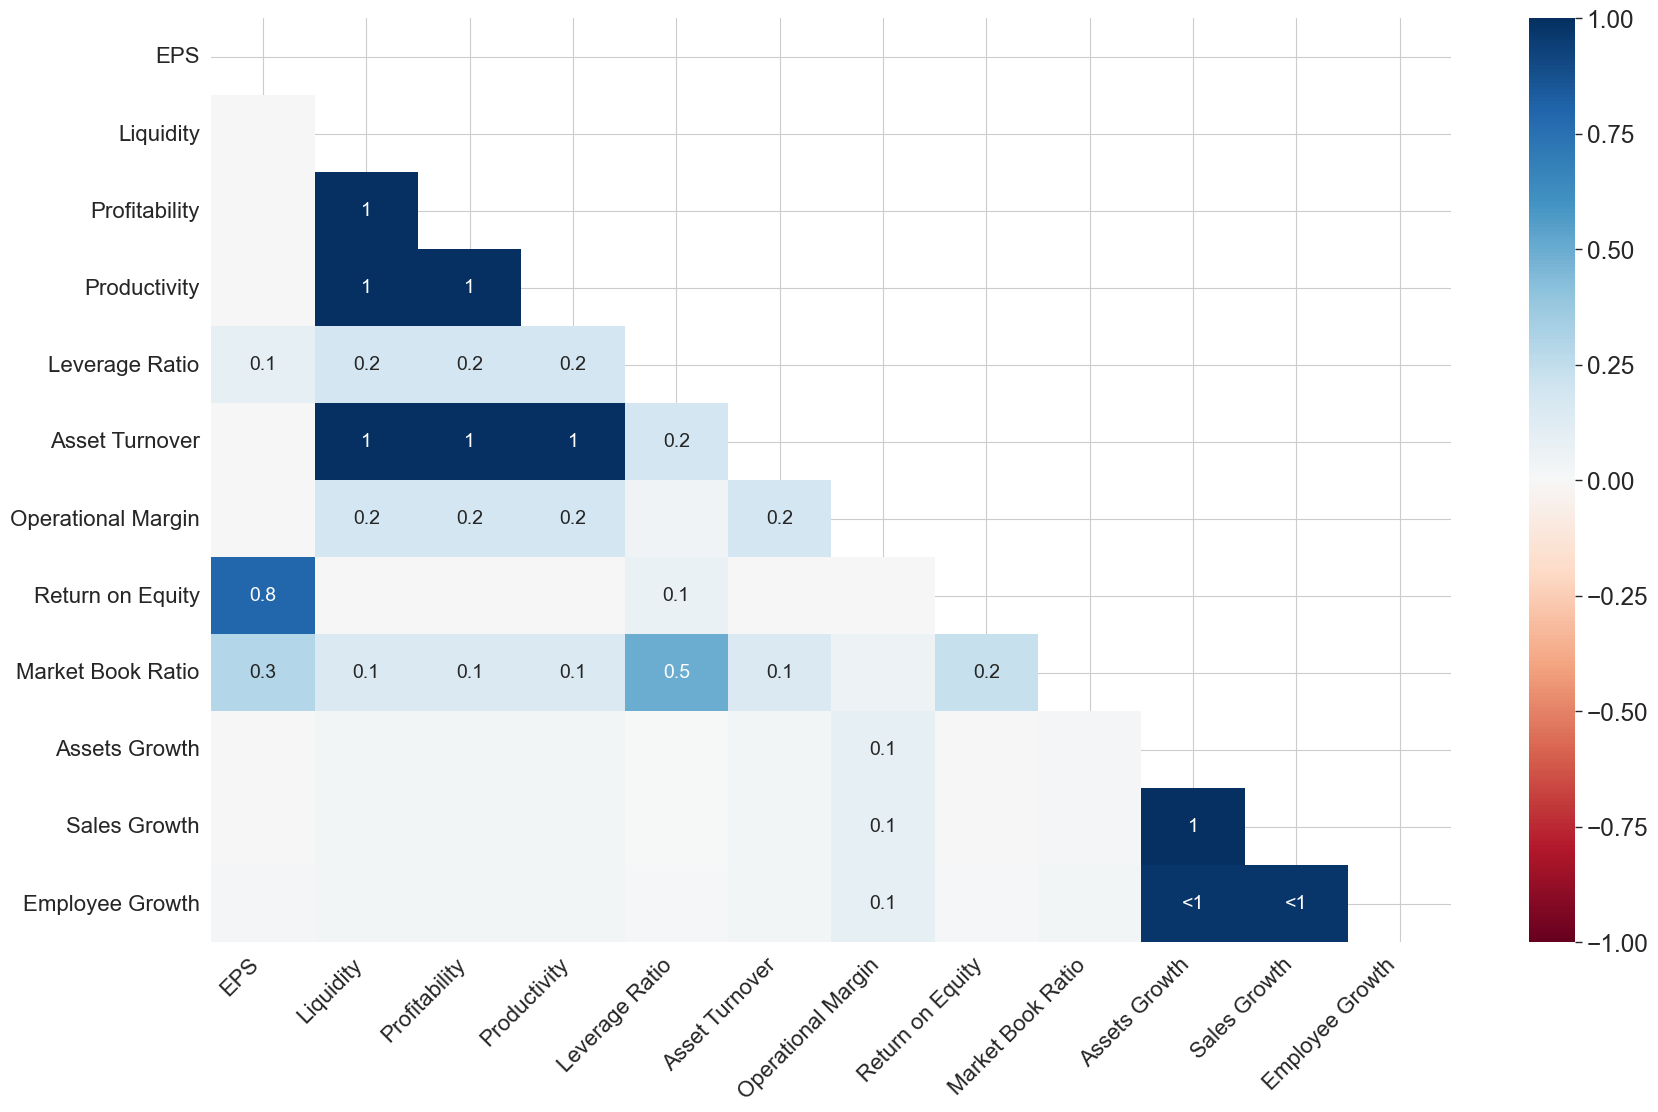

In [43]:
# trực quan hóa mối tương quan của dữ liệu bị thiếu giữa các cột
msno.heatmap(df)
plt.show()

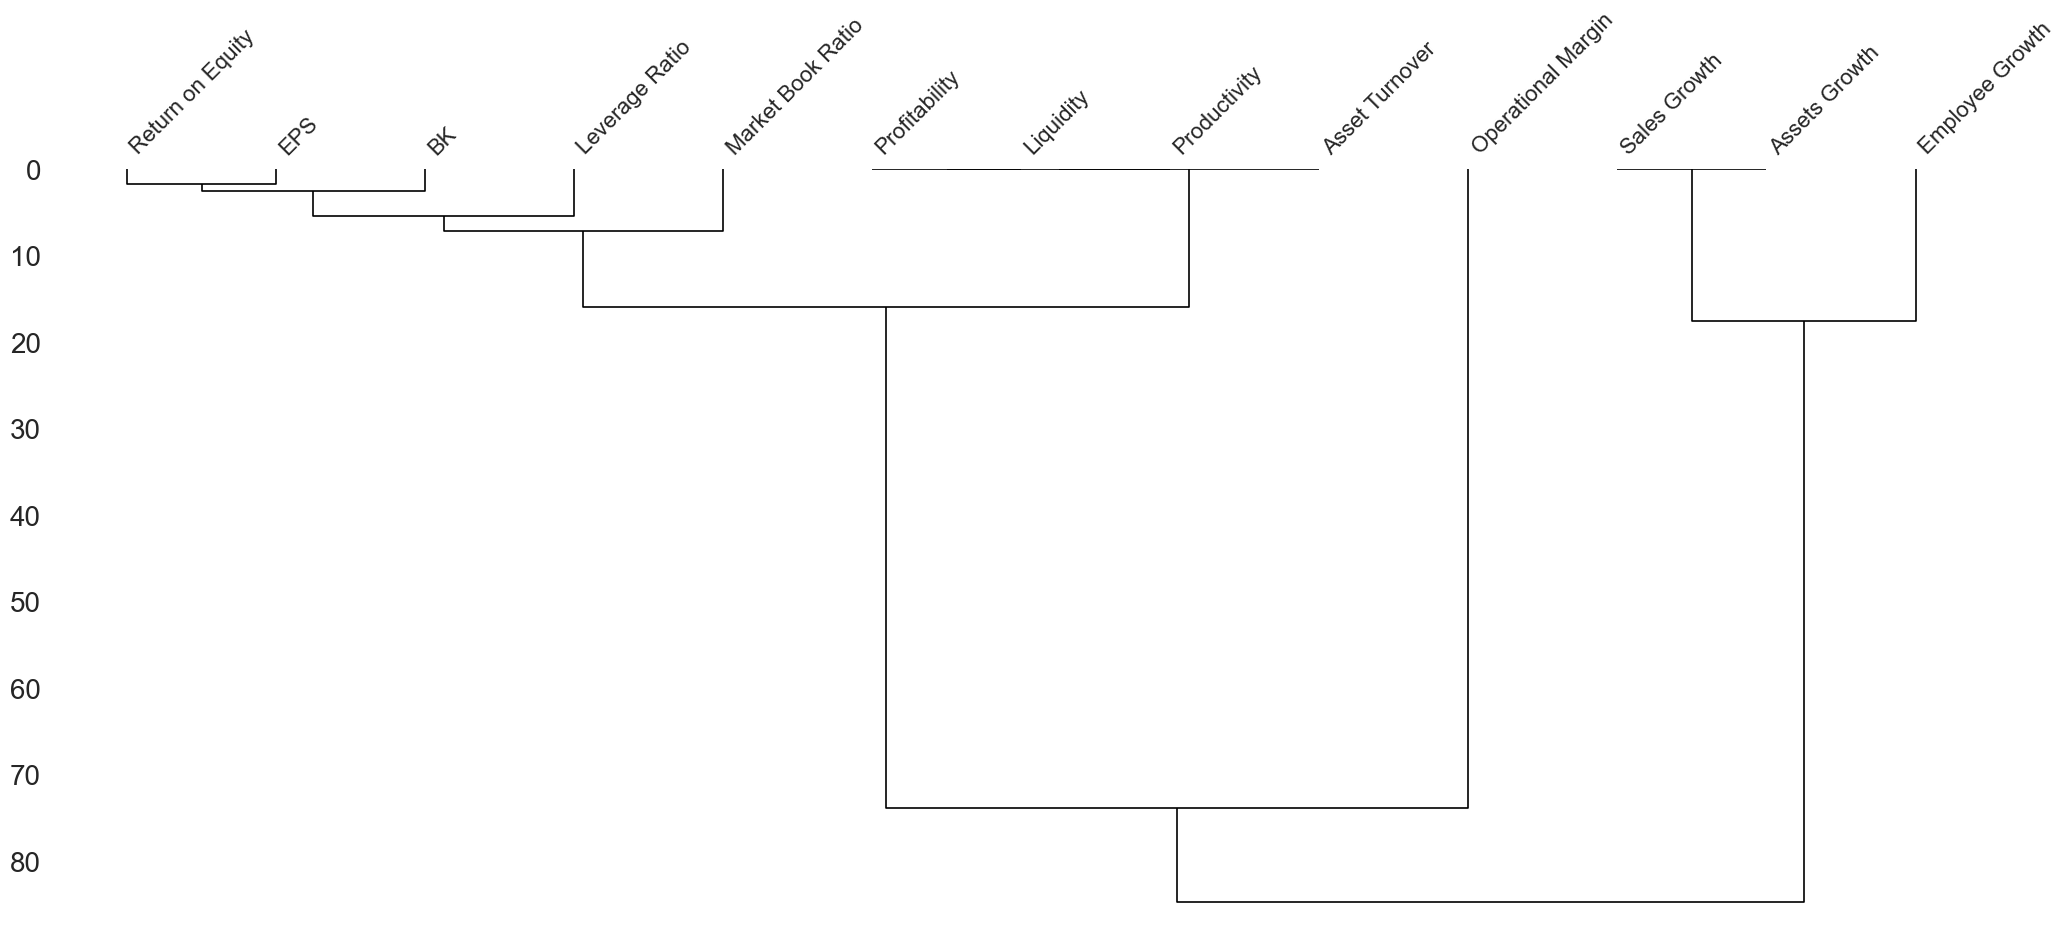

In [44]:
# Nhóm các cột bị thiếu dữ liệu cùng nhau
msno.dendrogram(df)
plt.show()

**Nhận xét:**

- Không cần loại bỏ bất kỳ đặc trưng nào vì tỉ lệ dữ liệu bị thiếu của từng đặc trưng đều dưới 20%

- Có mối tương quan cao giữa Asset Turnover, Profitability, Productivity và Liquidity; 100% các bản ghi bị thiếu dữ liệu ở những đặc trưng này trùng nhau

- Có mối tương quan cao giữa Assets Growth và Sales Growth; 100% các bản ghi bị thiếu dữ liệu ở những đặc trưng này trùng nhau, đồng thời hai đặc trưng này cũng có mối tương quan cao với Employee Growth

- Có mối tương quan cao giữa ROE và EPS

- Tương quan tương đối cao giữa Leverage Ratio và Market Book Ratio

Tiếp theo, ta kiểm tra tập con về Phá sản (Các sự kiện hiếm)

In [45]:
df_bankrupt = df[(df['BK']==1)]
df_bankrupt.shape

(558, 13)

In [46]:
# kiểm tra số lượng và tỉ lệ dữ liệu bị thiếu
checkmissing_df(df_bankrupt, "Columns_Bankrupt")

,counts_missing,percent_missing
Columns_Bankrupt,,
Employee Growth,72,12.9032
Operational Margin,17,3.0466
Market Book Ratio,9,1.6129
Return on Equity,4,0.7168
EPS,4,0.7168
Leverage Ratio,1,0.1792
Productivity,0,0.0000
Liquidity,0,0.0000
Profitability,0,0.0000


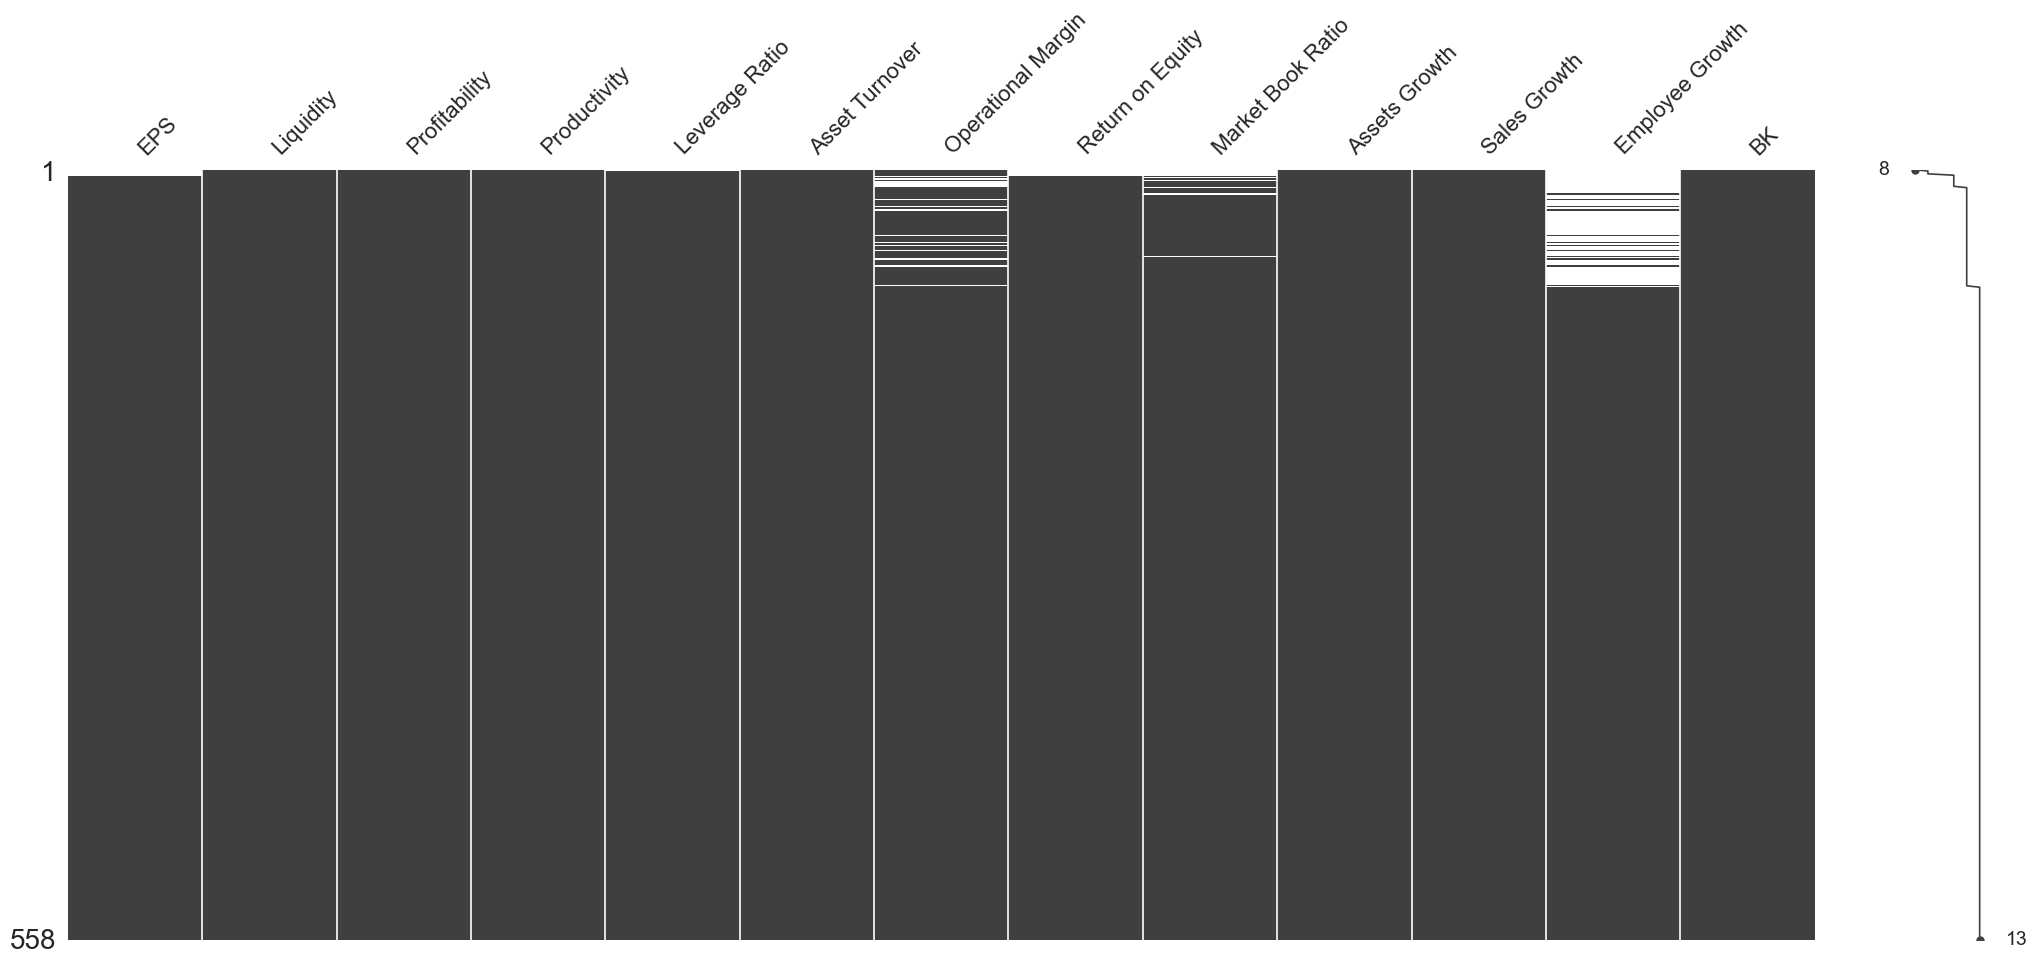

In [47]:
# Trực quan hóa để xem có các khối dữ liệu bị thiếu cùng nhau hay không
msno.matrix(df_bankrupt,sort = "ascending")
plt.show()

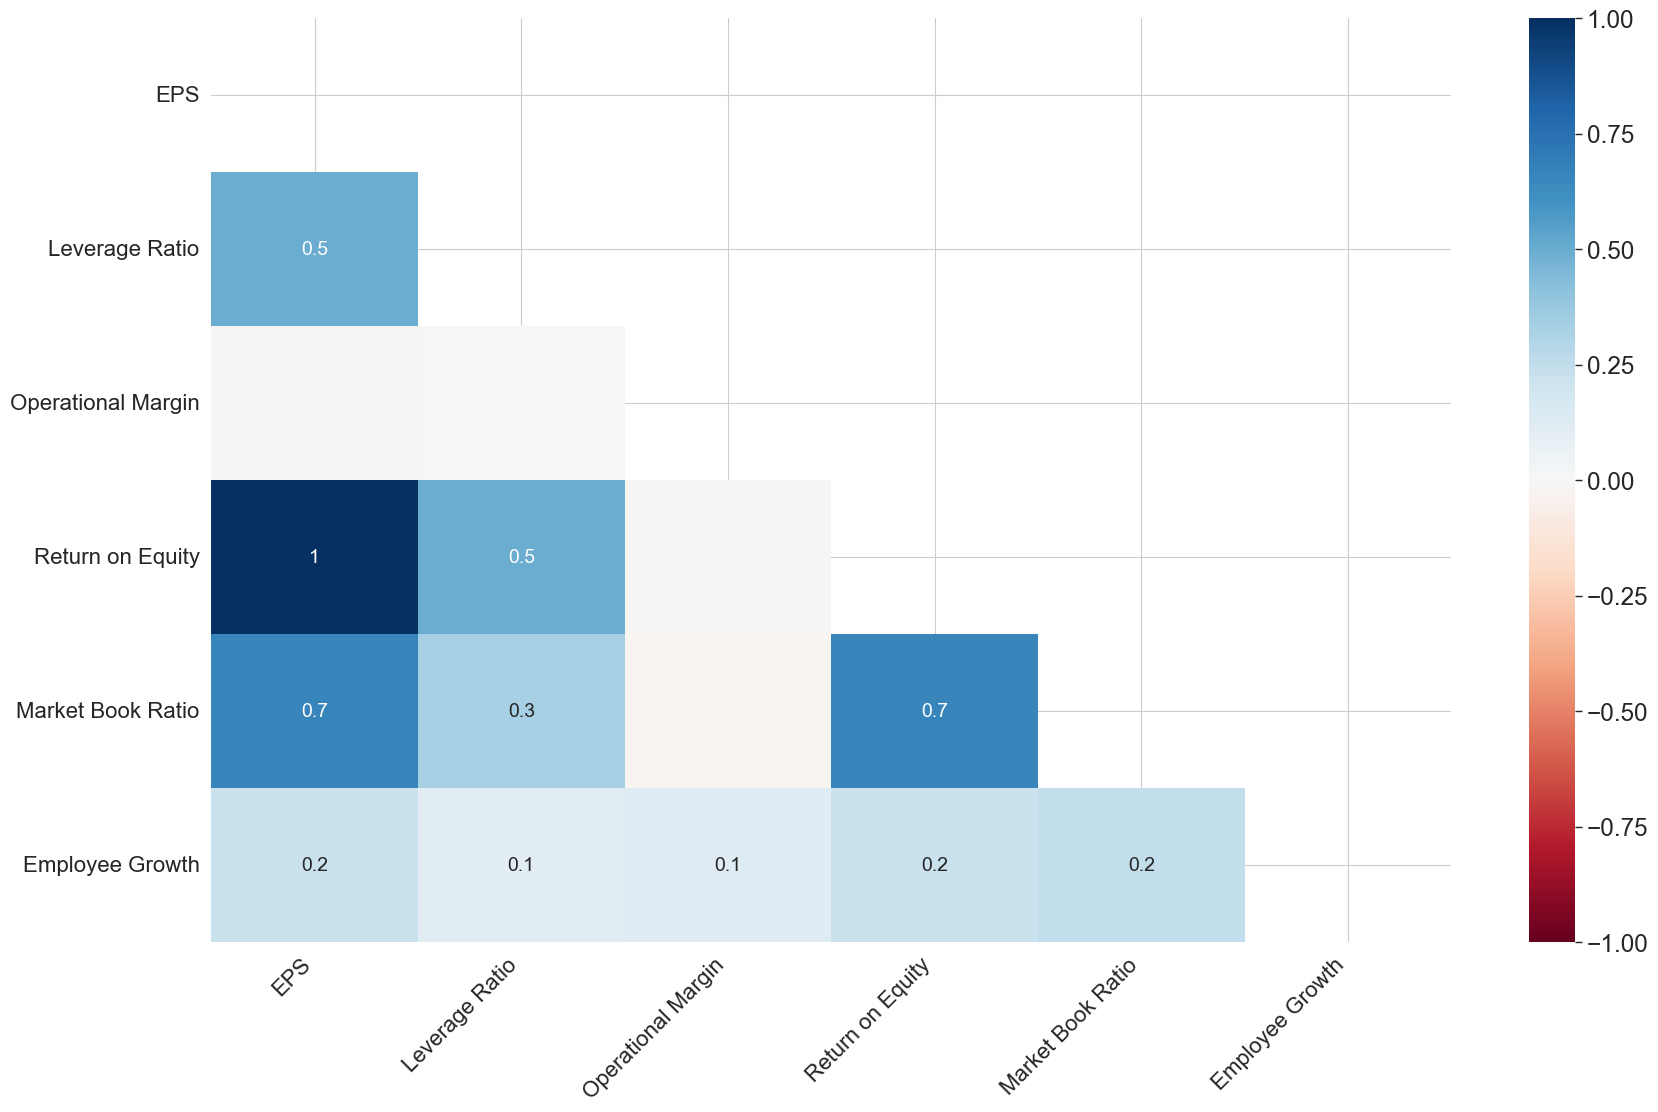

In [48]:
# Trực quan hóa mối tương quan của dữ liệu bị thiếu giữa các đặc trưng
msno.heatmap(df_bankrupt)
plt.show()

**Nhận xét về các mẫu phá sản:**

- Các mẫu bị thiếu dữ liệu ở ROE cũng bị thiếu EPS (100% trùng nhau)

- Có mối tương quan cao về dữ liệu bị thiếu giữa EPS và Market Book Ratio

- Có mối tương quan cao về dữ liệu bị thiếu giữa ROE và Market Book Ratio

KNNImputer phù hợp khi dữ liệu có các biến có tương quan cao, vì giá trị thiếu có thể dự đoán từ các biến liên quan. Đây sẽ là phương pháp ta sử dụng trong phần tiền xử lý dữ liệu.

## **3. Tiền xử lý dữ liệu**

Trong phần này, ta sẽ chia dữ liệu thành tập train và tập test, phục vụ cho việc huấn luyện và kiểm thử/đánh giá mô hình.

Đồng thời ta sẽ xử lý các vấn đề của dữ liệu mà ta đã phát hiện ở phần trước: giá trị bị thiếu, giá trị ngoại lai, dữ liệu bị lệch.

Cuối cùng, ta chuẩn hóa dữ liệu để đưa ra các biến cuối cùng phục vụ xây dựng mô hình.

### 3.1. Chia tập train và tập test

In [49]:
# Tách các đặc trưng và biến mục tiêu
X = df.drop('BK',axis=1)
y = df['BK']

In [50]:
# Chia bộ dữ liệu thành tập train và tập test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [51]:
# Kiểm tra kích thước của các phần dữ liệu được chia
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69633, 12), (23212, 12), (69633,), (23212,))

### 3.2. Điền giá trị cho dữ liệu bị thiếu

In [52]:
# Khởi tạo thuật toán
imputer = KNNImputer(
    n_neighbors=5,
    weights='distance',
    metric='nan_euclidean',
    add_indicator=False,
)

In [53]:
# Áp dụng bộ điền giá trị thiếu (imputer) lên dữ liệu huấn luyện
imputer.fit(X_train)

,missing_values,nan
,n_neighbors,5
,weights,'distance'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


Điều này giúp bộ điền học đặc điểm phân bố và cấu trúc dữ liệu thiếu trong tập huấn luyện, từ đó xây dựng quy tắc để sử dụng khi nội suy các giá trị bị thiếu. Sau khi bộ điền học xong, ta có thể áp dụng nó lên X_train và X_test để điền các giá trị bị thiếu.

In [54]:
# Điền các giá trị thiếu trong dữ liệu huấn luyện và dữ liệu kiểm tra
train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

Tiếp theo, ta cần chuyển kết quả sau khi impute từ NumPy array trở lại DataFrame,  
đồng thời gán lại tên các cột giống ban đầu để tiện xử lý tiếp.


In [55]:
# Tạo DataFrame cho các giá trị đã đầy đủ
train_t = pd.DataFrame(train_t, columns=X_train.columns)
test_t = pd.DataFrame(test_t, columns=X_test.columns)

In [56]:
train_t.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,-0.0300,0.9800,-0.1300,-0.1000,0.0000,0.0000,-20.0132,-0.0200,103.4900,1913.0000,0.0000,0.0000
1,-0.0100,-7.6600,-36.9600,-2.9200,-0.3800,0.0000,-27.6601,-0.0800,-263.9300,3.0360,-1.0000,0.0000
2,-0.4300,0.3100,-0.1700,-0.0900,0.0100,0.6400,-0.1400,-0.1700,37.0200,-0.0179,-0.0727,0.0034


In [57]:
test_t.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,1.2400,0.0300,0.1500,0.0600,0.5600,0.6600,0.0900,0.0800,49.8800,0.4120,0.5725,-0.0814
1,0.6700,0.1500,0.1100,0.3300,0.0000,0.7600,0.4400,0.1800,28.7700,3.7753,79.5067,0.3333
2,4.8000,-0.0200,0.3800,0.0800,0.6600,2.4600,0.0300,0.1300,67.8300,0.0923,0.0522,-0.4571


### 3.3. Xử lý giá trị ngoại lai

**Phương pháp được sử dụng: Winsorization**  
Winsorization – bất kỳ giá trị nào của một biến nằm trên hoặc dưới phần trăm thứ k ở mỗi phía của phân phối biến sẽ được thay bằng giá trị của phần trăm thứ k đó.

In [58]:
# Định nghĩa một hàm để tìm giới hạn trên và giới hạn dưới của các giá trị ngoại lai trong một biến cụ thể
def find_winsorboundaries(df, variable, lower_limit, upper_limit):

    lower_boundary = df[variable].quantile(lower_limit)
    upper_boundary = df[variable].quantile(1-upper_limit)

    return upper_boundary, lower_boundary

In [59]:
# Tính và in giới hạn winsorization (5% - 95%) cho từng biến,
# sử dụng dữ liệu huấn luyện để tránh rò rỉ thông tin từ tập test.
for column in train_t:
    RM_upper_limit, RM_lower_limit = find_winsorboundaries(
        X_train,
        column,
        0.05,
        0.05)
    print(
        f'The limits for column ({column}) are '
        f'({round(RM_upper_limit,2)}, {round(RM_lower_limit,2)})')

The limits for column (EPS) are (4.34, -1.86)
The limits for column (Liquidity) are (0.73, -0.47)
The limits for column (Profitability) are (0.64, -13.71)
The limits for column (Productivity) are (0.23, -1.19)
The limits for column (Leverage Ratio) are (2.73, -0.75)
The limits for column (Asset Turnover) are (2.67, 0.0)
The limits for column (Operational Margin) are (0.31, -4.23)
The limits for column (Return on Equity) are (0.16, -0.95)
The limits for column (Market Book Ratio) are (2159.11, -91.03)
The limits for column (Assets Growth) are (1.04, -0.39)
The limits for column (Sales Growth) are (0.97, -0.42)
The limits for column (Employee Growth) are (0.67, -0.33)


In [60]:
# Áp dụng Winsorization cho tất cả các cột
for column in train_t:

    # tìm giới hạn trên/dưới
    RM_upper, RM_lower = find_winsorboundaries(
        X_train,
        column,
        0.05,
        0.05
    )

    # Winsor hóa tập train
    train_t[column] = np.where(
        train_t[column] > RM_upper,
        RM_upper,
        np.where(train_t[column] < RM_lower, RM_lower, train_t[column])
    )

    # Winsor hóa tập test
    test_t[column] = np.where(
        test_t[column] > RM_upper,
        RM_upper,
        np.where(test_t[column] < RM_lower, RM_lower, test_t[column])
    )


In [61]:
train_t.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,-0.0300,0.7300,-0.1300,-0.1000,0.0000,0.0000,-4.2300,-0.0200,103.4900,1.0440,0.0000,0.0000
1,-0.0100,-0.4700,-13.7085,-1.1900,-0.3800,0.0000,-4.2300,-0.0800,-91.0285,1.0440,-0.4203,0.0000
2,-0.4300,0.3100,-0.1700,-0.0900,0.0100,0.6400,-0.1400,-0.1700,37.0200,-0.0179,-0.0727,0.0034


In [62]:
test_t.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,1.2400,0.0300,0.1500,0.0600,0.5600,0.6600,0.0900,0.0800,49.8800,0.4120,0.5725,-0.0814
1,0.6700,0.1500,0.1100,0.2300,0.0000,0.7600,0.3100,0.1599,28.7700,1.0440,0.9699,0.3333
2,4.3400,-0.0200,0.3800,0.0800,0.6600,2.4600,0.0300,0.1300,67.8300,0.0923,0.0522,-0.3333


### 3.4. Tái lấy mẫu dữ liệu huấn luyện bị lệch

In [63]:
# Khởi tạo SMOTE
sm = SMOTE(
    sampling_strategy='auto',
    random_state=21,
    k_neighbors=5
)

In [64]:
# Khởi tạo ENN
enn = EditedNearestNeighbours(
    sampling_strategy='auto',
    n_neighbors=3,
    kind_sel='all',
    n_jobs=-1)

In [65]:
# Kết hợp các phương pháp cân bằng lại dữ liệu
method = SMOTEENN(
    sampling_strategy='auto',
    random_state=21,
    smote=sm,
    enn=enn,
    n_jobs=-1
)

In [66]:
# Chỉ áp dụng tái lấy mẫu (resampling) cho dữ liệu huấn luyện
x_resampled, y_resampled = method.fit_resample(train_t,y_train)

### 3.5. Chuẩn hóa dữ liệu

Ta sử dụng phương pháp Robust Scaler.

In [67]:
# Ta chỉ chuẩn hóa các biến dự đoán, KHÔNG chuẩn hóa biến mục tiêu.

scaler = RobustScaler()

x_train_scaled = scaler.fit_transform(x_resampled)

x_test_scaled = scaler.transform(test_t)

Các biến được sử dụng để xây dựng model (tên trong ngoặc là về mặt ý nghĩa đầy đủ, không sử dụng để code)

- x_train_scaled (x_train_resampled_scaled)

- y_resampled (y_train_resampled)

- x_test_scaled (x_test_scaled)

- y_test (y_test)


## **4. Huấn luyện và đánh giá mô hình**

Ba thuật toán phân loại khác nhau được sử dụng để huấn luyện: Random Forest, Logistic Regression, và Naive Bayes.

Ngoài ra, thuật toán Voting Classifier cũng được triển khai để kết hợp dự đoán từ các thuật toán trên.

Các mô hình kết quả từ việc áp dụng các thuật toán này trên dữ liệu được đánh giá bằng nhiều chỉ số hiệu suất như độ chính xác (accuracy), độ chính xác dự đoán dương (precision), độ bao phủ (recall), F1-score, và AUC.

### 4.1. Mô hình Hồi quy Logistic

Logistic regression dự đoán xác suất thuộc về một lớp bằng cách dùng hàm logistc (sigmoid), rất hiệu quả cho các bài toán nhị phân. Mô hình kết quả của thuật toán này thường được dùng làm mô hình baseline (mô hình chuẩn để so sánh) nhờ tính đơn giản, tốc độ nhanh và khả năng giải thích rõ ràng.

#### 4.1.1. Huấn luyện mô hình

Trước tiên ta khởi tạo thuật toán Hồi quy Logistic bằng lớp LogisticRegression mà ta đã import.

In [68]:
logreg = LogisticRegression()

Tiếp theo ta tiến hành huấn luyện mô hình thông qua phương thức fit. Tập dữ liệu được sử dụng là x_train_scaled (tập đặc trưng để huấn luyện) và y_resampled (tập biến mục tiêu để huấn luyện). fit phải được thực hiện trên tập train, không được thực hiện trên tập test.


In [69]:
logreg.fit(x_train_scaled,y_resampled)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'



Sau khi huấn luyện, thuật toán đã thu được một bộ hệ số thể hiện mức độ ảnh hưởng của từng feature lên biến mục tiêu. Ta tạo một **DataFrame** để dễ quan sát và phân tích kết quả.

**Cột 1:** Tên các đặc trưng (feature names).

**Cột 2:** Giá trị hệ số tương ứng (Coef) của từng đặc trưng.

Trong đó ta sắp xếp các feature theo thứ tự giảm dần của hệ số Coef và hiển thị 10 feature đầu tiên.

In [70]:
coef = pd.DataFrame(X_train.columns, columns=["Features"])
coef['Coef'] = logreg.coef_.reshape(-1,1)
coef_sorted = coef.sort_values("Coef", ascending=False)
coef_sorted.head(10)

,Features,Coef
5,Asset Turnover,0.8672
4,Leverage Ratio,0.4722
2,Profitability,0.2844
9,Assets Growth,0.2636
6,Operational Margin,0.0493
11,Employee Growth,0.0214
10,Sales Growth,0.0153
8,Market Book Ratio,-0.0860
0,EPS,-0.5504
3,Productivity,-0.6662


Chỉ số Coef (hệ số) thể hiện mức độ ảnh hưởng của mỗi đặc trưng đến kết quả dự đoán của mô hình. Giá trị dương nghĩa là đặc trưng đó tăng khả năng thuộc về lớp mục tiêu (Asset Turnover, Leverage Ratio,...), giá trị âm nghĩa là đặc trưng đó giảm khả năng thuộc lớp mục tiêu (EPS, Productivity, Market Book Ratio).

Để áp dụng mô hình vừa học ta tiến hành dự đoán trên tập test, từ đó làm căn cứ để đánh giá khả năng dự đoán của mô hình.

#### 4.1.2. Dự đoán trên tập kiểm tra

Phương thức predict được sử dụng để dự đoán nhãn của dữ liệu mới dựa trên mô hình đã được huấn luyện. Khi gọi predict, mô hình sẽ áp dụng các tham số Coef đã học từ fit để xác định lớp cho từng mẫu trong tập kiểm tra. Nói cách khác, đây là bước sử dụng mô hình để đưa ra dự đoán.


In [71]:
y_pred = logreg.predict(x_test_scaled)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(23212,))

Phương thức predict trả về một mảng gồm các nhãn dự đoán cho từng bộ dữ liệu. Để dự đoán chi tiết hơn, ta sử dụng phương thức predict_proba() để dự đoán xác suất cho từng nhãn đối với mỗi bộ dữ liệu.

In [72]:
y_prob = logreg.predict_proba(x_test_scaled)

y_prob

array([[0.81584026, 0.18415974],
       [0.85145264, 0.14854736],
       [0.81972772, 0.18027228],
       ...,
       [0.88369801, 0.11630199],
       [0.79091421, 0.20908579],
       [0.80832972, 0.19167028]], shape=(23212, 2))

In [73]:
# Kiểm tra kích thước (shape), sẽ có hai cột, mỗi cột tương ứng với một lớp
y_prob.shape

(23212, 2)

Để thuận tiện cho việc xử lý và phân tích, ta chuyển kết quả về lại dạng Dataframe.

In [74]:
y_prob_df = pd.DataFrame(y_prob, index=y_test.index)

In [75]:
y_prob_df.head()

,0,1
49952,0.8158,0.1842
42044,0.8515,0.1485
34880,0.8197,0.1803
45390,0.8730,0.1270
77462,0.2779,0.7221


In [76]:
# Kiểm tra tập test có cùng số dòng với mảng lưu các dự đoán xác suất hay không
X_test.shape

(23212, 12)

Tiếp theo ta đặt tất cả dữ liệu vào một DataFrame để dễ phân tích, bao gồm xác suất dự đoán của từng nhãn, nhãn thực tế trong tập test và nhãn dự đoán bằng mô hình.

In [77]:
# Sao chép dữ liệu kiểm tra
df_results = X_test.copy()
# Thêm kết quả thực tế, dự đoán và xác suất dự đoán
df_results["Predicted_Prob_0"] = y_prob_df[0]
df_results["Predicted_Prob_1"] = y_prob_df[1]
df_results["Actual_Class"] = y_test
df_results["Predicted_Class"] = y_pred

labels = logreg.classes_ # phục vụ cho việc vẽ heatmap ở phần sau

In [78]:
# Xem kết quả
df_results.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,Predicted_Prob_0,Predicted_Prob_1,Actual_Class,Predicted_Class
49952,1.2400,0.0300,0.1500,0.0600,0.5600,0.6600,0.0900,0.0800,49.8800,0.4120,0.5725,-0.0814,0.8158,0.1842,0,0
42044,0.6700,0.1500,0.1100,0.3300,0.0000,0.7600,0.4400,0.1800,28.7700,3.7753,79.5067,0.3333,0.8515,0.1485,0,0
34880,4.8000,-0.0200,0.3800,0.0800,0.6600,2.4600,0.0300,0.1300,67.8300,0.0923,0.0522,-0.4571,0.8197,0.1803,0,0


#### 4.1.3. Kiểm tra hiệu suất mô hình

Sau khi đã tiến hành dự đoán trên tập test, chúng ta cần có cái nhìn tổng quan về khả năng dự đoán đúng của mô hình. Ma trận nhầm lẫn và Heatmap là các công cụ trực quan thực hiện tốt việc này.

##### Ma trận nhầm lẫn

In [79]:
# Lấy ma trận nhầm lẫn (Confusion Matrix)
cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
# Đưa vào DataFrame
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
# Xem DataFrame
cm_df

,0,1
0,19849,3212
1,41,110


Tiếp theo ta vẽ heatmap cho ma trận vừa tính

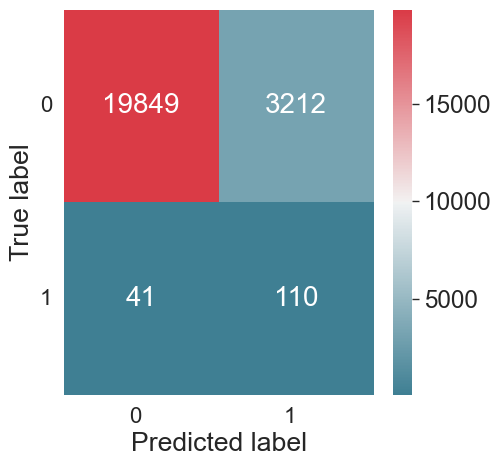

In [80]:
# Vẽ các thuộc tính
fig = plt.figure(figsize= (5,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Biểu đồ Heatmap của Seaborn - truyền ma trận nhầm lẫn
heatmap = sns.heatmap(cm_df,annot=True,annot_kws={"size": 20}, fmt="d", cmap=cmap)
# Các thuộc tính của Heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### Các chỉ số hiệu suất chính

In [81]:
# Định nghĩa một hàm để lấy các chỉ số hiệu suất chính
from sklearn import metrics as sk_metrics

def get_metrics(target,predicted,predicted_prob):
    accuracy = round(sk_metrics.accuracy_score(target,predicted)*100,2)
    error = round(100 - accuracy,2)
    precision = sk_metrics.precision_recall_fscore_support(target,predicted)[0][1]
    recall = sk_metrics.precision_recall_fscore_support(target,predicted)[1][1]
    f1 = sk_metrics.precision_recall_fscore_support(target,predicted)[2][1]
    auc = sk_metrics.roc_auc_score(target,predicted_prob)
    classification_report = sk_metrics.classification_report(target,predicted, digits = 4)


    print(f'''Accuracy: {accuracy}%
Error: {error}%
''')

    print("Classification Report")

    print(classification_report)

    print(f'AUC: {round(auc,2)}')

    return accuracy, precision, recall, f1, auc

In [82]:
# Lấy các xác suất
predict_proba_1 = df_results["Predicted_Prob_1"]

In [83]:
logreg_metrics = get_metrics(y_test,y_pred,predict_proba_1)

Accuracy: 85.99%
Error: 14.01%

Classification Report
              precision    recall  f1-score   support

           0     0.9979    0.8607    0.9243     23061
           1     0.0331    0.7285    0.0633       151

    accuracy                         0.8599     23212
   macro avg     0.5155    0.7946    0.4938     23212
weighted avg     0.9917    0.8599    0.9187     23212

AUC: 0.87


In [84]:
y_test

49952    0
42044    0
34880    0
45390    0
77462    0
        ..
39945    0
71092    0
69112    0
6409     0
43047    0
Name: BK, Length: 23212, dtype: int64

In [85]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(23212,))

Với mô hình baseline đơn giản như Logistic regression, chỉ số Accuracy đạt được với bộ dữ liệu này không cao, chỉ 85,99%, nhóm sẽ chỉ dùng kết quả từ mô hình này để so sánh với hiệu suất mô hình khác.

### 4.2. Mô hình Random Forest

Random Forest hoạt động bằng cách huấn luyện nhiều cây quyết định (decision trees) khác nhau và kết hợp kết quả của chúng để đưa ra dự đoán cuối cùng. Nhờ cơ chế “tập hợp nhiều cây", mô hình giảm overfitting, xử lý dữ liệu phức tạp tốt và thường cho độ chính xác cao trên nhiều loại bài toán phân loại.

#### 4.2.1. Huấn luyện mô hình

Tương tự như mô hình trước, ta cũng tiến hành khởi tạo thuật toán và huấn luyện mô hình bằng phương thức fit().

In [86]:
# Khởi tạo thuật toán
rf_model = RandomForestClassifier(n_estimators=10,max_features='sqrt',random_state=21)

In [87]:
# Huấn luyện mô hình
rf_model.fit(x_train_scaled,y_resampled)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### 4.2.2. Dự đoán trên tập kiểm tra

Sau khi mô hình đã được huấn luyện, ta áp dụng mô hình lên tập test, trước tiên là dự đoán nhãn.

In [88]:
# Dự đoán trên tập Test
y_pred_rf = rf_model.predict(x_test_scaled)

Tiếp theo ta dự đoán bằng xác suất.

In [89]:
# Dự đoán xác suất bằng hàm predict_proba
y_prob_rf = rf_model.predict_proba(x_test_scaled)

Kiểm tra kích thước của kết quả, sẽ phải có hai cột, mỗi cột tương ứng với một lớp

In [90]:
y_prob_rf.shape

(23212, 2)

Ta tạo một DaraFrame để lưu kết quả.

In [91]:
y_prob_df_rf = pd.DataFrame(y_prob_rf, index=y_test.index)

y_prob_df_rf.head(3)

,0,1
49952,1.0000,0.0000
42044,1.0000,0.0000
34880,1.0000,0.0000


#### 4.2.3. Kiểm tra hiệu suất mô hình

Trong phần này, ta tính ma trận nhầm lẫn và vẽ biểu đồ heatmap, tương tự như phần 4.1.3.

##### Ma trận nhầm lẫn

In [92]:
# Lấy ma trận nhầm lẫn
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf, labels=labels)
# Đưa vào DataFrame
cm_rf_df = pd.DataFrame(cm_rf, index=labels, columns=labels)
# Xem DataFrame
cm_rf_df

,0,1
0,22792,269
1,120,31


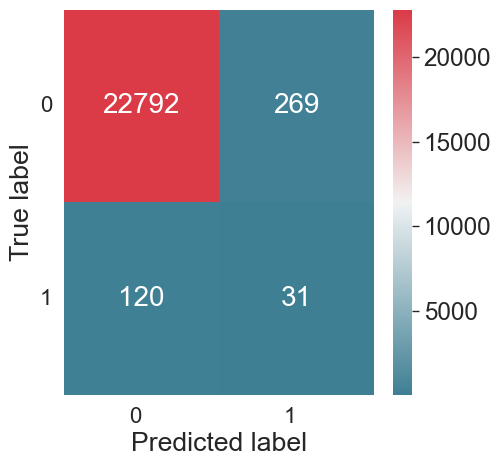

In [93]:
# Vẽ ma trận nhầm lẫn để dễ quan sát hơn
# Các thuộc tính của biểu đồ
fig = plt.figure(figsize= (5,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Heatmap của Seaborn - truyền ma trận nhầm lẫn vào
heatmap = sns.heatmap(cm_rf_df,annot=True,annot_kws={"size": 20}, fmt="d", cmap=cmap)
# Các thuộc tính của biểu đồ heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### Các chỉ số hiệu suất chính

In [94]:
rf_metrics = get_metrics(y_test,y_pred_rf,y_prob_df_rf[1])

Accuracy: 98.32%
Error: 1.68%

Classification Report
              precision    recall  f1-score   support

           0     0.9948    0.9883    0.9915     23061
           1     0.1033    0.2053    0.1375       151

    accuracy                         0.9832     23212
   macro avg     0.5490    0.5968    0.5645     23212
weighted avg     0.9890    0.9832    0.9860     23212

AUC: 0.82


Chỉ số Accuracy 98,32% cao vượt trội Logistic regression nhưng vẫn cần kiểm nghiệm thêm các mô hình khác để đạt các chỉ số khác precision, recall, f1-score tốt hơn.

### 4.3. Mô hình Naive Bayes

Mô hình Gaussian Naive Bayes là một thuật toán phân loại dựa trên định lý Bayes với giả định các đặc trưng độc lập và có phân phối chuẩn (Gaussian). GaussianNB rất nhanh, hiệu quả với dữ liệu nhiều chiều và hoạt động tốt ngay cả khi tập dữ liệu nhỏ hoặc nhiễu.

#### 4.3.1. Huấn luyện mô hình

Phần này khởi tạo thuật toán và tiến hành huấn luyện mô hình.

In [95]:
# Khởi tạo thuật toán
gnb = GaussianNB()

In [96]:
# Huấn luyện mô hình
gnb.fit(x_train_scaled,y_resampled)

,priors,None
,var_smoothing,1e-09


#### 4.3.2. Dự đoán trên tập kiểm tra

Trước tiên ta cũng dự đoán nhãn trên tập test

In [97]:
y_pred_gnb = gnb.predict(x_test_scaled)

In [98]:
y_pred_gnb

array([0, 0, 0, ..., 0, 0, 1], shape=(23212,))

Sau đó ta dự đoán xác suất cho nhãn bằng predict_proba.

In [99]:
# Dự đoán xác suất bằng hàm predict_proba
y_prob_gnb = gnb.predict_proba(x_test_scaled)

In [100]:
# Kiểm tra kích thước, sẽ có hai cột, mỗi cột tương ứng với một lớp
y_prob_gnb.shape

(23212, 2)

In [101]:
# Tạo một DataFrame để thuận tiện xử lý
y_prob_df_gnb = pd.DataFrame(y_prob_gnb, index=y_test.index)

y_prob_df_gnb.head(3)

,0,1
49952,0.9919,0.0081
42044,0.9973,0.0027
34880,1.0000,0.0000


#### 4.3.3 Kiểm tra hiệu suất mô hình

Tiếp tục vẽ ma trận nhầm lẫn và biểu đồ heatmap để quan sát hiệu suất mô hình một cách trực quan.

##### Ma trận nhầm lẫn

In [102]:
# Lấy ma trận nhầm lẫn
cm_gnb = metrics.confusion_matrix(y_test, y_pred_gnb, labels=labels)
# Đưa dữ liệu vào
cm_gnb_df = pd.DataFrame(cm_gnb, index=labels, columns=labels)
# Xem DataFrame
cm_gnb_df

,0,1
0,19018,4043
1,34,117


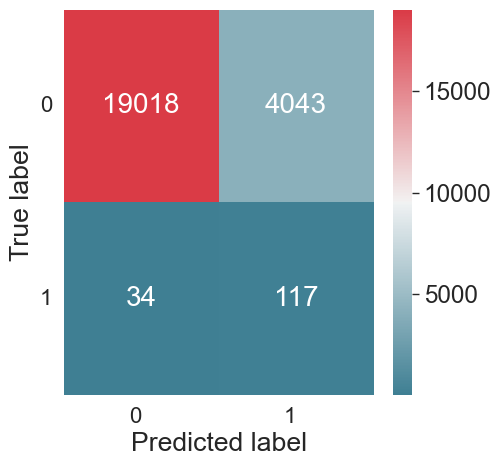

In [103]:
# Vẽ ma trận nhầm lẫn để dễ quan sát hơn
# Thuộc tính biểu đồ
fig = plt.figure(figsize= (5,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Biểu đồ Heatmap của Seaborn – truyền ma trận nhầm lẫn vào
heatmap = sns.heatmap(cm_gnb_df,annot=True,annot_kws={"size": 20}, fmt="d", cmap=cmap)
# Các thuộc tính của biểu đồ Heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### Các chỉ số chính

In [104]:
gnb_metrics = get_metrics(y_test,y_pred_gnb,y_prob_df_gnb[1])

Accuracy: 82.44%
Error: 17.56%

Classification Report
              precision    recall  f1-score   support

           0     0.9982    0.8247    0.9032     23061
           1     0.0281    0.7748    0.0543       151

    accuracy                         0.8244     23212
   macro avg     0.5132    0.7998    0.4787     23212
weighted avg     0.9919    0.8244    0.8977     23212

AUC: 0.86


Mô hình Naive Bayes có chỉ số accracy không quá cao.

Sau khi đi qua 3 mô hình trên, nhóm nhận thấy mỗi mô hình đều có lợi thế và hạn chế riêng. Tiếp theo, nhóm sẽ kết hợp 3 mô hình nhằm mang lại mô hình hiệu quả hơn mang tên Voting Classifier.

### 4.4. Mô hình Voting Classifier

Mô hình Voting Classifier kết hợp ba mô hình trước đó, tận dụng sức mạnh/ lợi thế của từng mô hình. Ta tiến hành khởi tạo và huấn luyện mô hình.

In [105]:
# Khởi tạo thuật toán
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=21)),
        ('rf', RandomForestClassifier(random_state=21)),
        ('nb', gnb)
    ],
    voting='soft'  # Dùng soft voting để tận dụng xác suất dự đoán
)

In [106]:
# Huấn luyện mô hình
voting_clf.fit(x_train_scaled,y_resampled)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [107]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(x_test_scaled, y_test))

lr = 0.8598569705324832
rf = 0.9834137515078407
nb = 0.824358090642771


Cuối cùng, ta thực hiện dự đoán trên tập test và tính metric cho các chỉ số hiệu suất chính.

In [108]:
# Dự đoán trên tập kiểm tra
y_pred_voting = voting_clf.predict(x_test_scaled)
y_proba_voting = voting_clf.predict_proba(x_test_scaled)[:, 1]  # dùng cho AUC

# Tính metrics (Các chỉ số hiệu suất chính)
voting_metrics = [
    accuracy_score(y_test, y_pred_voting) * 100,  # Accuracy %
    precision_score(y_test, y_pred_voting),
    recall_score(y_test, y_pred_voting),
    f1_score(y_test, y_pred_voting),
    roc_auc_score(y_test, y_proba_voting)
]

### 4.5. Lựa chọn mô hình tốt nhất

Ở đây, ta dùng tên của thuật toán huấn luyện mô hình để gọi tên mô hình kết quả. Chẳng hạn, mô hình kết quả được huấn luyện bởi thuật toán Logistic Regression được gọi là Mô hình Logistic Regression.

Các **chỉ số hiệu suất của từng mô hình** được **so sánh**, và kết quả được **trình bày dưới dạng bảng**.



In [109]:
# Tạo DataFrame cho tất cả các mô hình, bao gồm VotingClassifier
metric_labels = ("Accuracy (%)", "Precision","Recall", "F1 Score","AUC")
class_models = ("Logistic Regression","Random Forest","Naive Bayes", "Voting Classifier")
all_metrics = [logreg_metrics, rf_metrics, gnb_metrics, voting_metrics]

df_modelperf = pd.DataFrame(all_metrics, index=class_models, columns=metric_labels)

# Xem kết quả
print(df_modelperf)

                     Accuracy (%)  Precision  Recall  F1 Score    AUC
Logistic Regression       85.9900     0.0331  0.7285    0.0633 0.8747
Random Forest             98.3200     0.1033  0.2053    0.1375 0.8215
Naive Bayes               82.4400     0.0281  0.7748    0.0543 0.8641
Voting Classifier         89.1392     0.0396  0.6755    0.0749 0.8953


Dựa trên các chỉ số hiệu suất của 4 mô hình thử nghiệm (Logistic Regression, Random Forest, Naive Bayes và Voting Classifier), ta có một số nhận xét quan trọng:

**1. Accuracy (%):**

Random Forest có Accuracy cao nhất (98.32%), nhưng đây không phải là chỉ số duy nhất để đánh giá hiệu quả trên dữ liệu mất cân bằng.

Voting Classifier có Accuracy 89.15%, cao hơn Logistic Regression (85.99%) và Naive Bayes (82.44%).

**2. Precision và F1 Score:**

Cả 4 mô hình đều có Precision và F1 Score thấp, cho thấy mô hình gặp khó khăn trong việc dự đoán chính xác các mẫu dương tính (positive class).

Voting Classifier cải thiện nhẹ Precision (0.0390) và F1 Score (0.0736) so với các mô hình đơn lẻ, thể hiện khả năng cân bằng giữa nhiều mô hình.

**3. Recall:**

Naive Bayes và Logistic Regression có Recall cao (0.7748 và 0.7285), nghĩa là chúng phát hiện được nhiều mẫu dương tính, nhưng bù lại Precision thấp.

Voting Classifier có Recall 0.6623, thấp hơn một chút so với hai mô hình trên, nhưng kết hợp với các chỉ số khác, vẫn là lựa chọn cân đối.

**4. AUC:**

Voting Classifier có AUC cao nhất (0.8943), cho thấy khả năng phân biệt giữa các lớp tốt hơn hẳn các mô hình đơn lẻ.



**Nhận xét tổng quan:**

- Nếu chỉ quan tâm đến Accuracy, Random Forest có vẻ nổi bật, nhưng do dữ liệu mất cân bằng và các chỉ số Precision/F1 thấp, Accuracy cao chưa chắc phản ánh hiệu quả thực sự.

- Voting Classifier mặc dù không có Accuracy cao nhất, nhưng có AUC cao nhất và cải thiện đồng thời các chỉ số Precision, Recall và F1 so với các mô hình đơn lẻ.

- Điều này cho thấy Voting Classifier là mô hình cân bằng nhất và tổng thể tốt nhất cho bài toán hiện tại.



### 4.6. Đánh giá tính ổn định của mô hình Voting Classifier ##


Để kiểm tra tính ổn định (robustness) của mô hình Voting Classifier, nhóm sử dụng Stratified K-Fold Cross-Validation (K=5). Phương pháp này đảm bảo tỷ lệ lớp mục tiêu (phá sản/không phá sản) được giữ nguyên trong mỗi fold.

Với $K=5$, dữ liệu được chia thành 5 phần bằng nhau (mỗi phần giữ đúng tỷ lệ lớp). Quá trình diễn ra qua 5 lần:
- Lần 1: Dùng phần 1, 2, 3, 4 để học; dùng phần 5 để test.
- Lần 2: Dùng phần 1, 2, 3, 5 để học; dùng phần 4 để test.... Cứ thế xoay vòng cho đến khi mỗi phần đều được **test** một lần.

In [112]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline

# Định nghĩa mô hình tốt nhất: Voting Classifier
best_model = voting_clf

# Định nghĩa Stratified K-Fold
# K=5 là một lựa chọn phổ biến
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tạo một pipeline bao gồm cả bước Resampling và Mô hình
pipeline = ImbPipeline([
    ('resample', method),      # Bước SMOTEENN
    ('scaler', RobustScaler()), # Bước Scaling
    ('classifier', best_model)  # Mô hình Voting của bạn
])

# Chạy CV trên tập TRAIN GỐC (chưa Resample)
cv_auc_scores = cross_val_score(pipeline, train_t, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
cv_f1_scores = cross_val_score(pipeline, train_t, y_train, cv=skf, scoring='f1', n_jobs=-1)

# In kết quả
print("--- Stratified K-Fold Cross-Validation (K=5) ---")
print(f"Mô hình: Voting Classifier")
print(f"Điểm AUC (5 folds): {cv_auc_scores}")
print(f"AUC Trung bình: {np.mean(cv_auc_scores):.4f} (+/- {np.std(cv_auc_scores):.4f})")
print(f"")
print(f"Điểm F1 (5 folds): {cv_f1_scores}")
print(f"F1 Trung bình: {np.mean(cv_f1_scores):.4f} (+/- {np.std(cv_f1_scores):.4f})")

--- Stratified K-Fold Cross-Validation (K=5) ---
Mô hình: Voting Classifier
Điểm AUC (5 folds): [0.88109148 0.91104123 0.89903725 0.90304206 0.86961911]
AUC Trung bình: 0.8928 (+/- 0.0152)

Điểm F1 (5 folds): [0.06734435 0.07433628 0.07506361 0.07814408 0.06762029]
F1 Trung bình: 0.0725 (+/- 0.0043)


Thay vì tin vào kết quả kiểm tra duy nhất vốn có thể do yếu tố ngẫu nhiên, việc lấy trung bình hiệu suất từ 5 lần lặp giúp nhóm khẳng định chắc chắn mô hình Voting Classifier hoạt động bền bỉ, không bị quá khớp (overfitting) và có khả năng nhận diện rủi ro chính xác trên tập dữ liệu.

## **5. Kết luận**



Chọn Voting Classifier làm mô hình cuối cùng vì nó tận dụng sức mạnh kết hợp từ các mô hình Logistic Regression, Random Forest và Naive Bayes, mang lại hiệu suất ổn định và khả năng phân loại tốt hơn, đặc biệt khi dữ liệu mất cân bằng.

Kết quả chạy Stratified K-Fold Cross-Validation (K=5) trên toàn bộ tập dữ liệu đã xác nhận tính ổn định và khả năng tổng quát hóa vượt trội của mô hình:

- AUC Trung bình đạt 0.8928 (với độ lệch chuẩn chỉ +/- 0.0152).

- F1 Trung bình đạt 0.0725 (với độ lệch chuẩn chỉ +/- 0.0043).

- Tính Ổn định (Robustness): Độ lệch chuẩn cực kỳ thấp của cả hai chỉ số chứng minh rằng mô hình Voting Classifier hoạt động nhất quán và hiệu quả không thay đổi đáng kể trên các phân đoạn dữ liệu khác nhau.

- Mặc dù chỉ số F1 đạt 0.0725 (phản ánh đặc thù của dữ liệu mất cân bằng cực đoan 0.6%), nhưng mô hình đã tối ưu hóa được chỉ số Recall. Trong lĩnh vực tài chính, việc nhận diện được các doanh nghiệp sắp phá sản (giảm thiểu sót lỗi) được ưu tiên cao hơn việc dự báo nhầm, nhằm bảo vệ tối đa nguồn vốn cho nhà đầu tư.

**Kết quả này củng cố mạnh mẽ cho lựa chọn mô hình Voting Classifier là giải pháp tối ưu cho bài toán dự đoán phá sản.**

## **6. Đề xuất nghiên cứu thêm**



Mặc dù Voting Classifier cho hiệu suất tổng thể tốt nhất, Precision và F1 Score vẫn còn thấp, cho thấy khó dự đoán chính xác các mẫu dương tính. Hướng nghiên cứu tiếp theo có thể tập trung vào tối ưu tham số, thử nghiệm các mô hình ensemble nâng cao (XGBoost, LightGBM) và cải thiện chọn lọc đặc trưng để nâng cao khả năng phân loại mẫu dương tính và hiệu suất tổng thể.

**Triển khai mô hình XGBoost**

In [ ]:
from xgboost import XGBClassifier

# Tính toán trọng số dựa trên tỉ lệ mất cân bằng
# ratio = số mẫu âm (0) / số mẫu dương (1)
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

# Tạo scaler mới fit trên dữ liệu gốc trước khi resampling
scaler_xgb = RobustScaler()
x_train_original_scaled = scaler_xgb.fit_transform(train_t)
x_test_scaled_xgb = scaler_xgb.transform(test_t)

xgb_weighted = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=ratio,  # Xử lý dữ liệu mất cân bằng
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss', 
    verbosity=0
)

# Huấn luyện trên dữ liệu gốc chưa SMOTE
xgb_weighted.fit(x_train_original_scaled, y_train)

# Dự đoán và Đánh giá
y_pred_w = xgb_weighted.predict(x_test_scaled_xgb)
y_proba_w = xgb_weighted.predict_proba(x_test_scaled_xgb)[:, 1]

print("--- XGBoost với scale_pos_weight (Không SMOTE) ---")
xg_metrics = get_metrics(y_test, y_pred_w, y_proba_w)

--- XGBoost với scale_pos_weight (Không SMOTE) ---
Accuracy: 91.78%
Error: 8.22%

Classification Report
              precision    recall  f1-score   support

           0     0.9977    0.9194    0.9570     23061
           1     0.0525    0.6821    0.0975       151

    accuracy                         0.9178     23212
   macro avg     0.5251    0.8008    0.5272     23212
weighted avg     0.9916    0.9178    0.9514     23212

AUC: 0.91


In [121]:
# Tạo DataFrame cho tất cả các mô hình, bao gồm VotingClassifier
metric_labels = ("Accuracy (%)", "Precision","Recall", "F1 Score","AUC")
class_models = ("Logistic Regression","Random Forest","Naive Bayes", "Voting Classifier","XGBoost")
all_metrics = [logreg_metrics, rf_metrics, gnb_metrics, voting_metrics, xg_metrics]

df_modelperf = pd.DataFrame(all_metrics, index=class_models, columns=metric_labels)

# Xem kết quả
print(df_modelperf)

                     Accuracy (%)  Precision  Recall  F1 Score    AUC
Logistic Regression       85.9900     0.0331  0.7285    0.0633 0.8747
Random Forest             98.3200     0.1033  0.2053    0.1375 0.8215
Naive Bayes               82.4400     0.0281  0.7748    0.0543 0.8641
Voting Classifier         89.1392     0.0396  0.6755    0.0749 0.8953
XGBoost                   91.7800     0.0525  0.6821    0.0975 0.9075


Sau khi thử nghiệm và so sánh, XGBoost (với *scale_pos_weight*) là mô hình tối ưu nhất cho bài toán dự báo phá sản với các ưu điểm vượt trội:

- Đạt chỉ số AUC là $0.9075$ (mức xuất sắc), cao hơn mô hình Voting Classifier và vượt xa các mô hình đơn lẻ.

- Mặc dù ưu tiên Recall để không bỏ sót doanh nghiệp phá sản (đạt $0.6821$), XGBoost vẫn cải thiện được Precision lên mức $0.0525$, giúp giảm bớt tỉ lệ báo động sai so với các phương pháp truyền thống.

- Mô hình không bị đánh lừa bởi Accuracy cao (như Random Forest) mà tập trung vào mục tiêu cốt lõi là nhận diện rủi ro trong bối cảnh dữ liệu cực kỳ mất cân bằng.

**ROC Curve của các mô hình**

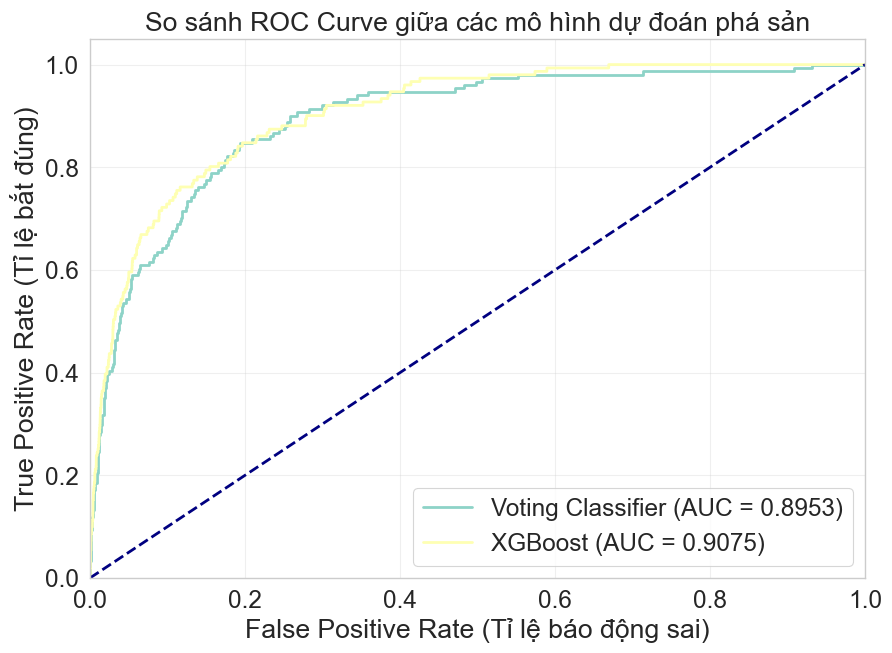

In [ ]:
from sklearn.metrics import roc_curve, auc

# 1. Tính toán FPR, TPR và AUC cho từng mô hình
models_proba = {
    'Voting Classifier': y_proba_voting[:, 1] if hasattr(y_proba_voting, 'ndim') and y_proba_voting.ndim > 1 else y_proba_voting,
    'XGBoost': y_proba_w
}

plt.figure(figsize=(10, 7))

for name, proba in models_proba.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

# 2. Vẽ đường chéo 50/50 (Random Guess)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 3. Tinh chỉnh biểu đồ
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Tỉ lệ báo động sai)')
plt.ylabel('True Positive Rate (Tỉ lệ bắt đúng)')
plt.title('So sánh ROC Curve giữa các mô hình dự đoán phá sản')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Nhận xét: 

- Đường cong của XGBoost nằm cao nhất và gần góc trên bên trái nhất (AUC > 0.9) cho thấy mô hình có năng lực phân loại tốt cho bộ dữ liệu.

- Cả hai mô hình (XGB và Voting) đều có độ dốc ban đầu rất lớn, cho thấy chỉ cần chấp nhận một tỉ lệ nhỏ "báo động sai" (FPR), mô hình đã có thể bắt được một lượng lớn các ca phá sản thực tế.


**Confusion Matrix và Specificity - XGBoost**

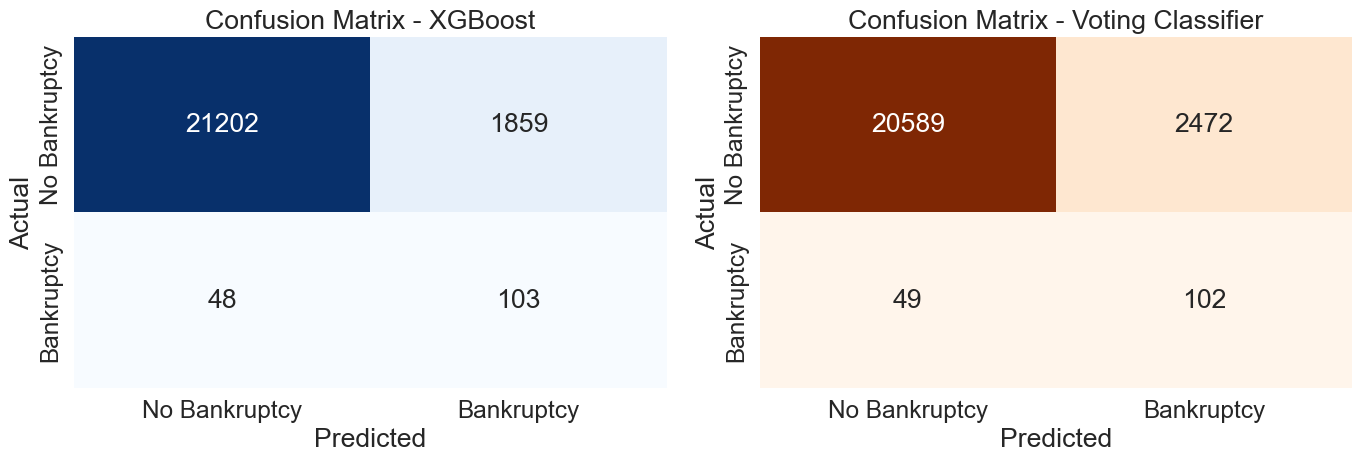


=== SPECIFICITY (TNR) - Tỉ lệ phân loại đúng mô hình lành mạnh ===
XGBoost Specificity: 0.9194
Voting Classifier Specificity: 0.8928


In [ ]:
from sklearn.metrics import confusion_matrix

# Tính Confusion Matrix cho XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_w)

# Vẽ Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost Confusion Matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix - XGBoost')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_xticklabels(['No Bankruptcy', 'Bankruptcy'])
axes[0].set_yticklabels(['No Bankruptcy', 'Bankruptcy'])

# Voting Classifier Confusion Matrix
cm_voting = confusion_matrix(y_test, y_pred_voting)
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Oranges', ax=axes[1], cbar=False)
axes[1].set_title('Confusion Matrix - Voting Classifier')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
axes[1].set_xticklabels(['No Bankruptcy', 'Bankruptcy'])
axes[1].set_yticklabels(['No Bankruptcy', 'Bankruptcy'])

plt.tight_layout()
plt.show()

# Tính Specificity (TNR - True Negative Rate)
print("\n=== SPECIFICITY (TNR) - Tỉ lệ phân loại đúng mô hình lành mạnh ===")
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()
specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)

tn_voting, fp_voting, fn_voting, tp_voting = cm_voting.ravel()
specificity_voting = tn_voting / (tn_voting + fp_voting)

print(f"XGBoost Specificity: {specificity_xgb:.4f}")
print(f"Voting Classifier Specificity: {specificity_voting:.4f}")

Mô hình vẫn giữ được khả năng nhận diện đúng $92\%$ các công ty khỏe mạnh, đây là chỉ số rất cao, giúp tránh làm phiền các doanh nghiệp đang hoạt động tốt.

**Feature Importance - Các feature ảnh hưởng nhất**

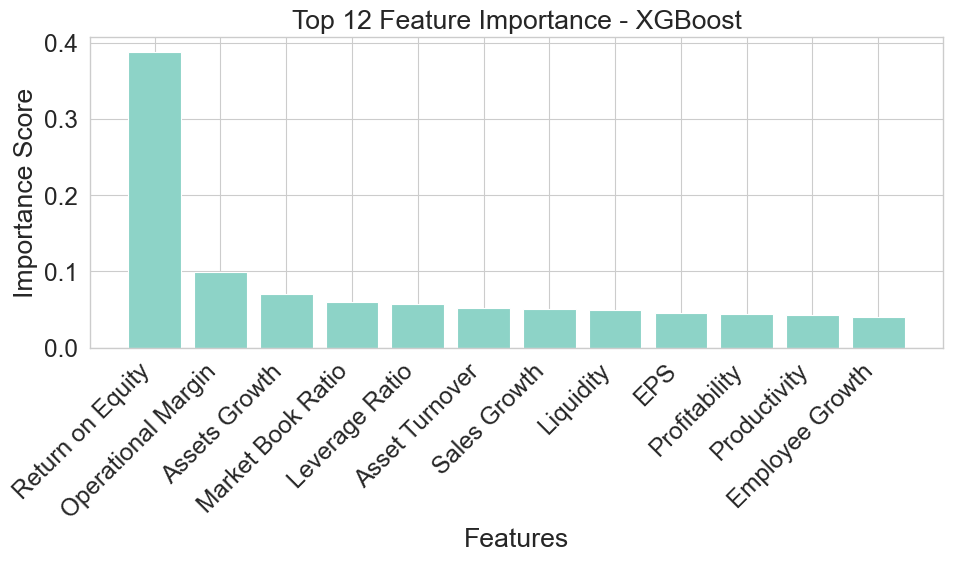


=== TOP 10 FEATURE IMPORTANCE ===
1. Return on Equity: 0.3880
2. Operational Margin: 0.0997
3. Assets Growth: 0.0702
4. Market Book Ratio: 0.0601
5. Leverage Ratio: 0.0573
6. Asset Turnover: 0.0524
7. Sales Growth: 0.0504
8. Liquidity: 0.0499
9. EPS: 0.0451
10. Profitability: 0.0441


In [134]:
# Feature Importance từ XGBoost
importances_xgb = xgb_weighted.feature_importances_

# Lấy tên các feature từ train_t
feature_names = train_t.columns

# Sắp xếp theo độ quan trọng giảm dần
num_features_to_show = min(15, len(importances_xgb))
indices = np.argsort(importances_xgb)[::-1][:num_features_to_show]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.title(f'Top {num_features_to_show} Feature Importance - XGBoost')
plt.bar(range(num_features_to_show), importances_xgb[indices])
plt.xticks(range(num_features_to_show), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

print(f"\n=== TOP 10 FEATURE IMPORTANCE ===")
for i, idx in enumerate(indices[:10]):
    print(f"{i+1}. {feature_names[idx]}: {importances_xgb[idx]:.4f}")

Nhận xét: 

- ROE (Return on Equity - Tỷ suất lợi nhuận trên vốn chủ sở hữu) là chỉ số tài chính quan trọng đo lường hiệu quả sử dụng vốn của doanh nghiệp. Trong dự báo phá sản, ROE âm hoặc sụt giảm nghiêm trọng là dấu hiệu sớm nhất cho thấy doanh nghiệp đang ăn vào vốn chủ sở hữu. Mô hình đặt ROE lên hàng đầu là rất hợp lý (trọng số gần 39%), vì đây là chỉ số tổng hợp phản ánh sức khỏe tài chính cuối cùng của một công ty.

- Operational Margin chiếm gần 10%, là tỷ suất lợi nhuận hoạt động cho biết hiệu quả từ hoạt động kinh doanh cốt lõi. Cách biệt giữa ROE và Operational Margin là rất lớn (khoảng gần 30%), cho thấy mô hình phụ thuộc cực kỳ nhiều vào ROE để đưa ra quyết định, trong khi các chỉ số còn lại đóng vai trò hỗ trợ tinh chỉnh dự đoán.

- Nhóm chỉ số tăng trưởng - Assets Growth (0.0702) & Sales Growth (0.0504): cho thấy mô hình nhận diện được mối liên hệ giữa sự đình trệ (hoặc sụt giảm quy mô) và nguy cơ phá sản. Một doanh nghiệp không còn khả năng tăng trưởng doanh số thường dễ rơi vào bẫy nợ nần.

- Chỉ số đầu tiên (ROE) chiếm trọng số quá lớn. Điều này có lợi là khiến mô hình dễ giải thích, nhưng cũng có rủi ro rằng nếu dữ liệu về ROE của một doanh nghiệp bị sai lệch hoặc thiếu, mô hình có thể dự báo sai hoàn toàn.

- Việc các chỉ số như Leverage Ratio và Operational Margin lọt vào Top 5 cho thấy mô hình đã học được quy luật kinh tế cơ bản: Một doanh nghiệp phá sản thường do sự kết hợp của việc kinh doanh không có lãi và nợ quá cao.

**Matthews Correlation Coefficient (MCC) - Chỉ số tốt cho imbalanced data**

In [135]:
from sklearn.metrics import matthews_corrcoef

print("=== MATTHEWS CORRELATION COEFFICIENT (MCC) ===")
print("MCC là chỉ số tốt cho imbalanced data, giá trị từ -1 đến 1")
print("(1 = dự đoán hoàn hảo, 0 = random, -1 = ngược lại hoàn toàn)\n")

mcc_xgb = matthews_corrcoef(y_test, y_pred_w)
mcc_voting = matthews_corrcoef(y_test, y_pred_voting)

print(f"XGBoost MCC: {mcc_xgb:.4f}")
print(f"Voting Classifier MCC: {mcc_voting:.4f}")

# So sánh tất cả các chỉ số
print("\n" + "="*70)
print("BẢNG TÓM LẠI CÁC CHỈ SỐ ĐÁNH GIÁ")
print("="*70)

eval_data = {
    'Model': ['XGBoost', 'Voting Classifier'],
    'Accuracy': [accuracy_score(y_test, y_pred_w)*100, accuracy_score(y_test, y_pred_voting)*100],
    'Precision': [precision_score(y_test, y_pred_w), precision_score(y_test, y_pred_voting)],
    'Recall': [recall_score(y_test, y_pred_w), recall_score(y_test, y_pred_voting)],
    'F1 Score': [f1_score(y_test, y_pred_w), f1_score(y_test, y_pred_voting)],
    'Specificity': [specificity_xgb, specificity_voting],
    'AUC': [roc_auc_score(y_test, y_proba_w), roc_auc_score(y_test, y_proba_voting)],
    'MCC': [mcc_xgb, mcc_voting]
}

df_eval = pd.DataFrame(eval_data)
print(df_eval.to_string(index=False))

=== MATTHEWS CORRELATION COEFFICIENT (MCC) ===
MCC là chỉ số tốt cho imbalanced data, giá trị từ -1 đến 1
(1 = dự đoán hoàn hảo, 0 = random, -1 = ngược lại hoàn toàn)

XGBoost MCC: 0.1738
Voting Classifier MCC: 0.1455

BẢNG TÓM LẠI CÁC CHỈ SỐ ĐÁNH GIÁ
            Model  Accuracy  Precision  Recall  F1 Score  Specificity    AUC    MCC
          XGBoost   91.7844     0.0525  0.6821    0.0975       0.9194 0.9075 0.1738
Voting Classifier   89.1392     0.0396  0.6755    0.0749       0.8928 0.8953 0.1455


Chỉ số MCC (0.1738) của XGBoost là một minh chứng quan trọng cho độ tin cậy của mô hình. Trong bối cảnh dữ liệu mất cân bằng cực đoan, MCC là thước đo khắt khe và khách quan nhất. Việc đạt được giá trị dương ổn định cho thấy mô hình không chỉ bắt được các ca phá sản (Recall) mà còn duy trì được sự cân bằng trên toàn bộ tập dữ liệu, vượt xa hiệu suất của một bộ phân loại ngẫu nhiên.

## **7. Tài liệu tham khảo**





1) [DATA-SCIENCE-FOR-FINANCE/ Bankruptcy Prediction - serkannpolatt](https://github.com/serkannpolatt/DATA-SCIENCE-FOR-FINANCE/tree/main/Bankruptcy%20Prediction)
2) [Bankruptcy Prediction Using Machine Learning Techniques](https://www.mdpi.com/1911-8074/15/1/35)
3) [Bankruptcy Prediction Using Machine Learning Models](https://ijsrem.com/download/predicting-bankruptcy-with-machine-learning-models/)
4) [Ứng dụng học máy trong dự báo rủi ro phá sản](https://ktpt.neu.edu.vn/Uploads/Bai%20bao/2023/So%20310/380842.pdf)